<h1>Predicting H1N1 and Seasonal Flu Vaccine Uptake using Behavioral and Demographic Data: A Multilabel Classification Approach<h1>

Dalam notebook ini, kita akan memodelkan data untuk memprediksi seberapa besar kemungkinan seseorang menerima dua jenis vaksin, yaitu h1n1 vaccine dan seasonal vaccine. Analisis dimulai dengan Exploratory Data Analysis, dilanjutkan dengan data preprocessing sebelum akhirnya data dimodelkan. Algoritma yang digunakan adalah catBoost Classifier yang di optimisasi (fine-tune) menggunakan Optuna dan cross validation. Model dievaluasi menggunakan ROC AUC Score, berhasil mendapatkan score 86,6% pada saat training dan ROC AUC Score 100% pada saat testing.


# Table of Content

- [Introduction](#introduction)
- [Exploratory Data Analysis (EDA)](#eda)
    - [1. Structure Investigation](#1)
        - [1.1 Structure of non-numerical features](#1.1)
        - [1.2 Structure of numerical features](#1.2)
        - [1.3 Conclusion of structure investigation](#1.3)
    - [2. Quality investigation](#2)
        - [2.1 Duplicates](#2.1)
        - [2.2 Missing Values](#2.2)
        - [2.3 Unwanted entries and recording errors](#2.3)
    - [3. Content investigation](#3)
        - [3.1 Feature Distribution](#3.1)
        - [3.2 Correlation](#3.2)
- [Data Preprocessing](#prepro)
    - [Data Imputation](#imputation)
    - [Data Partitioning](#partition)
    - [Encoding Categorical Data](#encoding)
    - [Feature Selection](#fs)
- [Modelling](#modelling)
- [Retrain on Full Dataset](#retrain)
- [Make a Submission](#submission)

In [ ]:
!pip install catboost -q
!pip install optuna -q
!pip -q install --upgrade mlxtend 
!pip -q install --upgrade joblib
!pip -q install category_encoders
!pip install pycaret[full] -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from catboost import CatBoostClassifier, Pool, cv
import optuna

from category_encoders import OneHotEncoder as ohe

from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

<a id="eda"></a>
# Exploratory Data Analysis (EDA)

Kita akan membagi proses EDA menjadi 3 bagian, yaitu :
1. Structure investigation: Eksplorasi bentuk umum dari dataset, serta tipe data dari fitur-fitur yang ada.
2. Quality investigation: Melihat gambaran kualitas dataset, data duplikat, missing values dan entri yang salah (data inkonsisten).
3. Content investigation: Eksplorasi lebih detail pada nilai-nilai fitur, distribusi, dan melihat korelasi antar fitur

<a id="1"></a>
## 1. Structure investigation
Pada bagian ini, kita akan mengeksplorasi bentuk dataset secara umum, serta melihat tipe data dari setiap fitur. Mari kita mulai dengan pertanyaan, berapa banyak kolom dan baris yang terdapat pada dataset? Dan berapa banyak jenis tipe data yang termasuk pada fitur-fitur tersebut?

In [ ]:
!wget -q https://github.com/maulairfani/DataScience-Learning-Notebooks/raw/main/dac-find-it-2023.zip?raw=true

import zipfile
with zipfile.ZipFile("/content/dac-find-it-2023.zip?raw=true", 'r') as zip_ref:
    zip_ref.extractall("")

In [ ]:
# Read CSV
features = pd.read_csv("/content/training_set_features.csv")
labels = pd.read_csv("/content/training_set_labels.csv")

In [ ]:
# Show size of the dataset
print("Shape of features dataframe:", features.shape)
print("Shape of labels dataframe:", labels.shape)

Shape of features dataframe: (26707, 36)
Shape of labels dataframe: (26707, 3)


Kita memiliki 2 dataframe, features dan labels. dataframe features terdiri dari variabel-variabel prediktor, sedangkan dataframe labels terdiri dari variabel-variabel target.

di setiap dataframe terdapat kolom id, sebagai unique value untuk setiap observasi, tetapi kita tidak akan menggunakannya dalam proses training nantinya. sehingga kita bisa simpulkan bahwa dataframe features memiliki 35 variabel, dataframe labels memiliki 2 variabel, serta keduanya memiliki 26707 observasi

<a id="1.1"></a>
### 1.1 Structure of non-numerical features

Tipe data dapat berupa numerik dan non-numerik. Pertama-tama, mari kita lihat lebih detail fitur-fitur non-numerik. 

In [ ]:
features.select_dtypes(include="O").head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb


Dari output di atas, terdapat beberapa variabel yang telah dienkripsi, seperti `hhs_geo_region`, `employment_industry`, dan `employment_occupation`.

Selain itu, terdapat variabel dengan skala nominal dan ordinal. Skala nominal adalah jenis skala yang digunakan untuk membedakan objek-objek berdasarkan karakteristik atau atribut yang dimilikinya, tanpa adanya urutan atau tingkatan tertentu. Variabel dengan skala nominal antara lain `race`, `sex`, `marital_status`, `rent_or_own`, `employment_status`, `hhs_geo_region`, `census_msa`, `employment_industry`, dan `employment_occupation`.

Sementara itu, skala ordinal digunakan untuk menunjukkan urutan atau tingkatan dari suatu variabel, di mana nilai-nilai dalam skala tersebut memiliki tingkat perbedaan yang sama. Fitur dengan skala ordinal pada dataset ini adalah `age_group`, `education`, dan `income_poverty`. Informasi ini diperlukan untuk menentukan strategi encoding yang akan digunakan untuk mengubah variabel-variabel tersebut menjadi data numerik yang dapat diproses oleh algoritma Machine Learning.

In [ ]:
features.describe(exclude="number")

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


Output tersebut menampilkan deskripsi statistik dari fitur-fitur yang memiliki tipe data non-numerik. Deskripsi tersebut meliputi informasi seperti jumlah data yang tersedia, jumlah nilai unik pada setiap fitur, nilai yang paling sering muncul (modus), dan frekuensi nilai modus.

Kita dapat melihat bahwa variabel employment_industry dan employment_occupation memiliki jumlah kategori yang cukup banyak (> 20). Jika kita menerapkan one-hot encoding pada variabel ini, dataset kita akan memiliki terlalu banyak fitur. Oleh karena itu, kita perlu menangani hal ini dengan strategi seperti one-hot encoding lalu feature selection, atau menggunakan label encoding saja. Tentu saja ada banyak strategi lain yang dapat dicoba.

kita dapat melihat bahwa mayoritas responden berusia di atas 65 tahun (kategori "65+ Years"), memiliki tingkat pendidikan sarjana (kategori "College Graduate"), dan berjenis kelamin perempuan (kategori "Female").

Selain itu, terdapat fitur-fitur yang memiliki missing value seperti "employment_industry" dan "employment_occupation". Hal ini dapat berdampak pada analisis dan pemodelan data yang akan dilakukan, sehingga perlu dicari solusi untuk menangani missing value tersebut. Analisis lebih lanjut terkait missing value akan dibahas di bagian selanjutnya.

Informasi lain yang menarik pada dataset ini adalah proporsi responden dengan ras kulit putih yang dominan dan mayoritas responden tinggal di rumah yang dimiliki sendiri (tidak menyewa). Hal ini dapat memberikan wawasan tambahan terkait karakteristik populasi sebenarnya dari dataset ini.

<a id="1.2"></a>
### 1.2 Structure of numerical features
Next, let’s take a closer look at the numerical features. Lebih tepatnya, kita akan mengecek berapa banyak nilai unik yang dimiliki setiap fitur. Proses ini akan memberikan kita wawasan mengenai fitur-fitur yang bersifat biner (2 nilai unik) dan yang tidak. Selain itu kita juga akan mengecek skala data dari setiap fitur

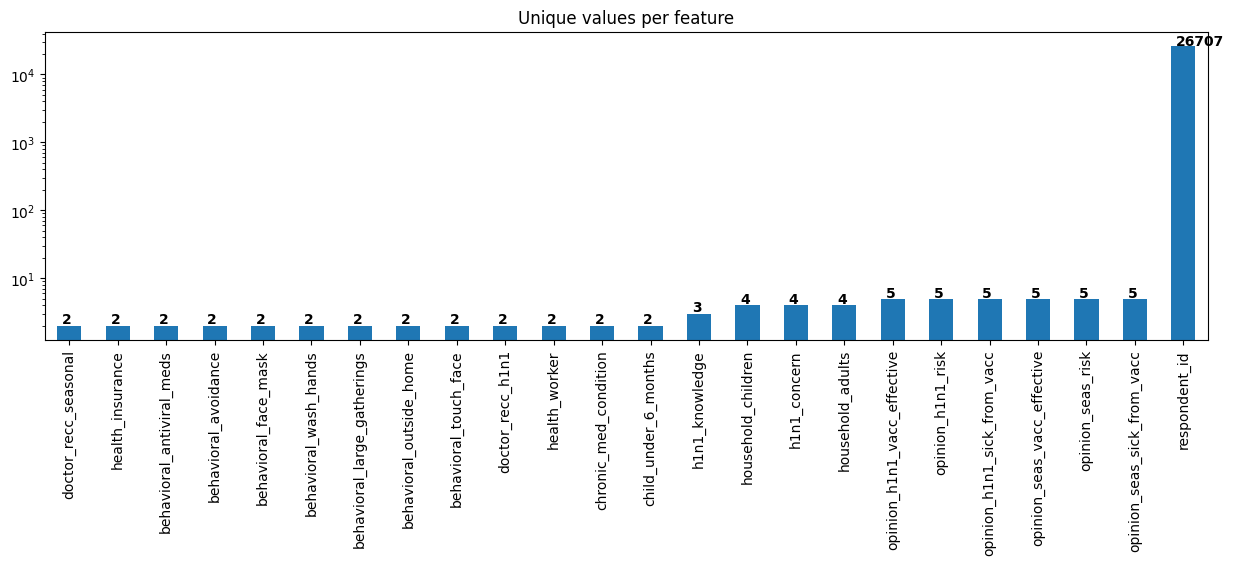

In [ ]:
# For each numerical feature compute number of unique entries
unique_values = features.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
ax = unique_values.plot.bar(logy=True, figsize=(15, 4),title="Unique values per feature")
for i, v in enumerate(unique_values):
    ax.text(i-0.15, v+0.2, str(v), color='black', fontweight='bold')
plt.show()

Kita dapat melihat bahwa fitur-fitur tersebut memiliki jumlah nilai unik yang bervariasi, dari 2 hingga 5 nilai unik.

Selain itu, fitur "respondent_id" memiliki jumlah nilai unik yang sama dengan jumlah baris dalam dataset, yaitu 26707. Hal ini menunjukakan bahwa fitur tersebut merupakan kolom identitas unik untuk setiap responden dan tidak memberikan informasi tambahan yang berguna untuk analisis.

Kita dapat mengetahui skala data dari setiap fitur numerik. Beberapa kolom seperti `h1n1_concern`, `h1n1_knowledge`, `opinion_h1n1_vacc_effective`, `opinion_h1n1_risk`, `opinion_h1n1_sick_from_vacc`, `opinion_seas_vacc_effective`, `opinion_seas_risk`, dan `opinion_seas_sick_from_vacc` memiliki nilai unik kurang dari 10, dengan mempertimbangkan deskripsi data  serta domain knowledge tentang variabel terkait, kita bisa anggap fitur-fitur itu sebagai variabel ordinal. Sedangkan, kolom-kolom lainnya hanya memiliki 2 nilai unik, sehingga dapat dianggap sebagai variabel biner nominal.

<a id="1.3"></a>
### 1.3 Conclusion of structure investigation

Dalam analisis struktur dataset, terdapat 35 variabel prediktor pada dataframe features dan 2 variabel target pada dataframe labels, dengan total 26707 observasi. Variabel-variabel ini memiliki tipe data numerik dan non-numerik, dengan beberapa variabel yang telah dienkripsi. Terdapat fitur-fitur dengan skala nominal dan ordinal, serta fitur-fitur numerik dengan jumlah nilai unik yang bervariasi. Beberapa variabel memiliki nilai yang hilang. Selain itu, terdapat fitur-fitur numerik dengan jumlah nilai unik yang bervariasi, dan fitur "respondent_id" merupakan kolom identitas unik yang tidak memberikan informasi tambahan yang berguna untuk analisis.

<a id="2"></a>
## 2. Quality investigation

Get a feeling for the general quality of the dataset, with regards to duplicates, missing values and unwanted entries.

### 2.1. Duplicates
Duplicates adalah data yang merepresentasikan satu titik sampel yang sama beberapa kali. Hal ini dapat menyebabkan bias dalam analisis dan interpretasi data, sehingga perlu untuk diidentifikasi dan dihapus dari dataset.

In [ ]:
# Check number of duplicates while ignoring the index feature
n_duplicates = features.drop(labels=["respondent_id"], axis=1).duplicated().sum()
print(f"We seem to have {n_duplicates} duplicates in our features dataset.")

We seem to have 0 duplicates in our features dataset.


<a id="2.2"></a>
### 2.2 Missing values
Kita juga perlu memeriksa apakah terdapat nilai yang hilang dalam dataset karena missing values dapat mempengaruhi kualitas analisis kita.

#### 2.2.1. Per sample

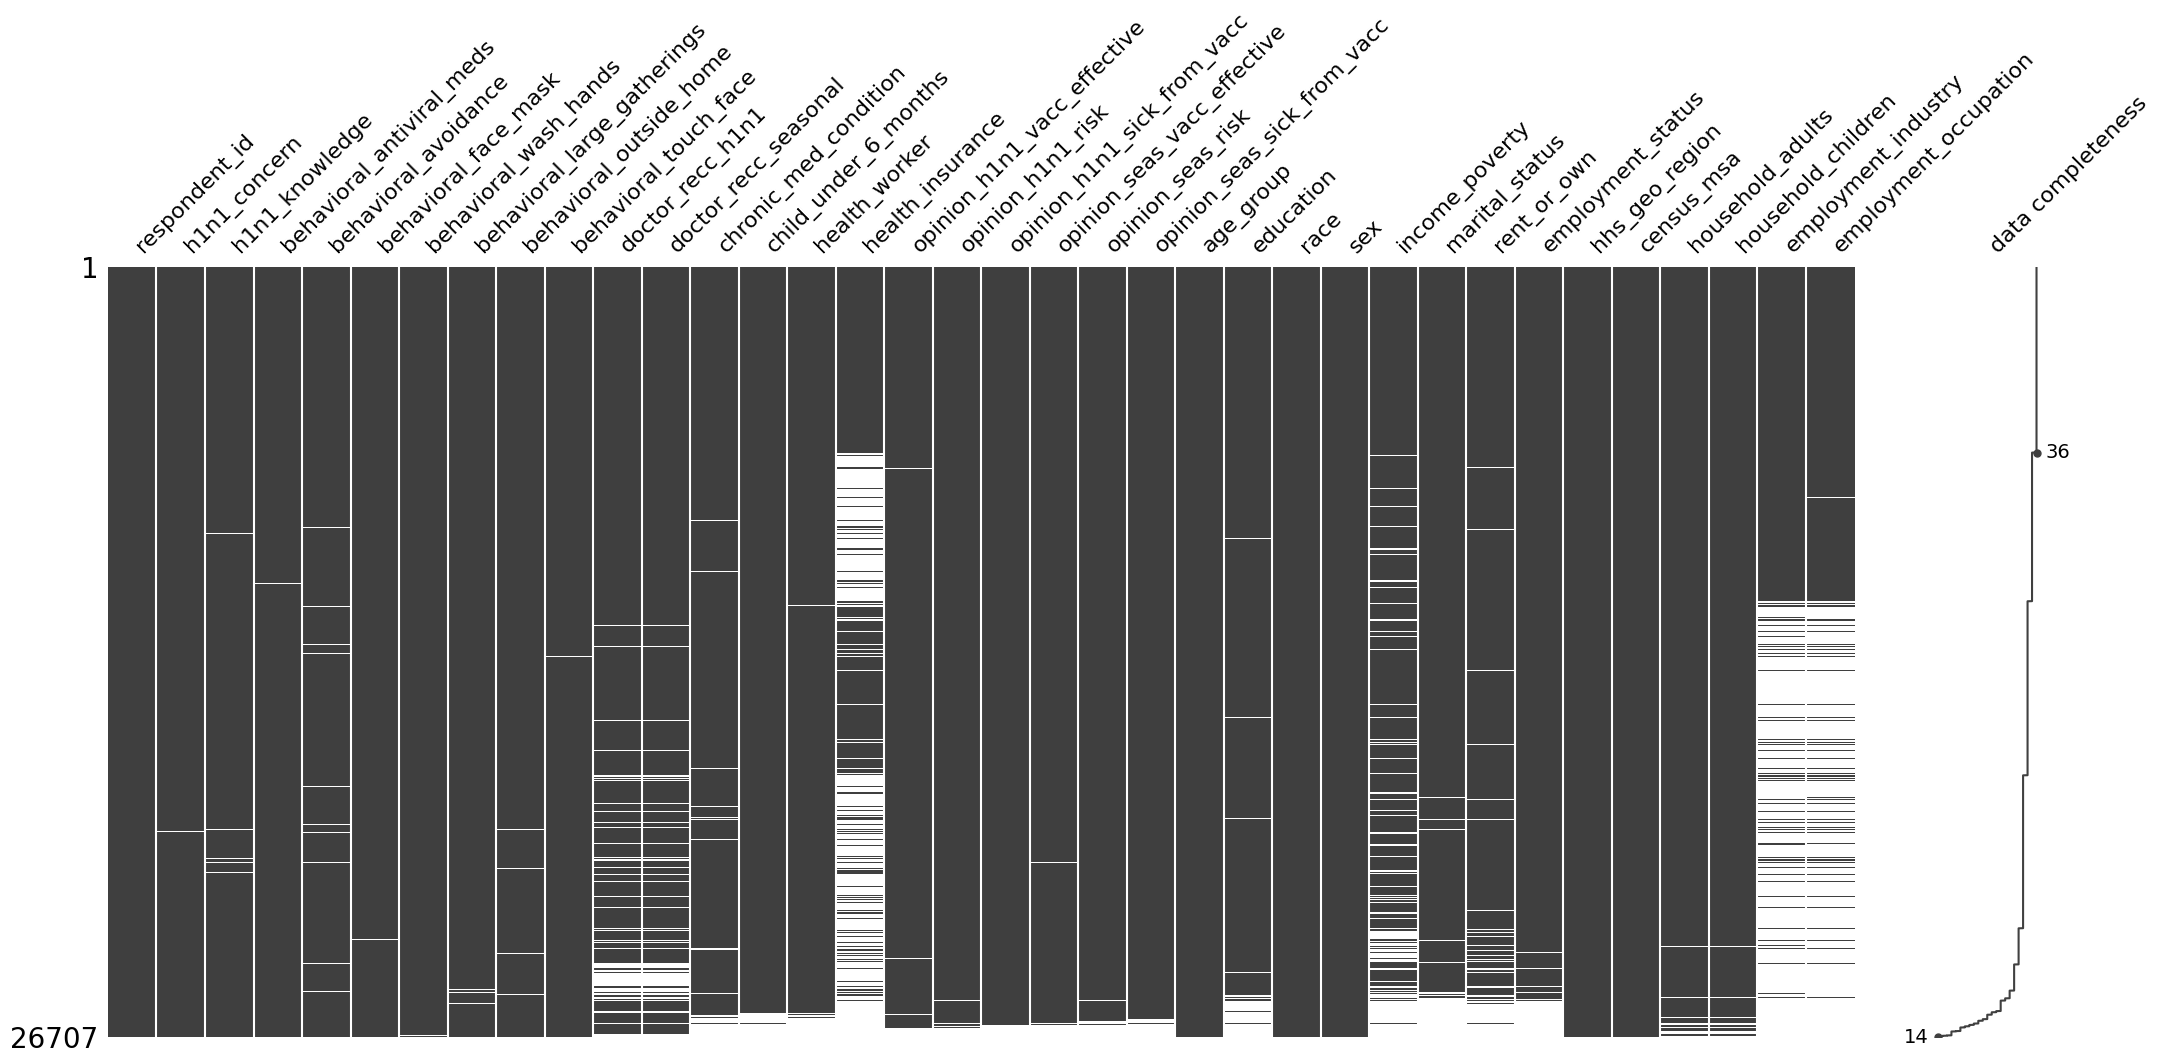

In [ ]:
msno.matrix(features, labels=True, sort="descending");

In [ ]:
missing_values_count = features.isnull().sum(axis=1)
for i in range(2, 8):
    high_missing_values_samples = missing_values_count[missing_values_count > (i/10 * features.shape[1])]
    print(f"Terdapat {high_missing_values_samples.count()}\tsampel yang memiliki missing values > {i*10}%")

Terdapat 1263	sampel yang memiliki missing values > 20%
Terdapat 773	sampel yang memiliki missing values > 30%
Terdapat 419	sampel yang memiliki missing values > 40%
Terdapat 192	sampel yang memiliki missing values > 50%
Terdapat 2	sampel yang memiliki missing values > 60%
Terdapat 0	sampel yang memiliki missing values > 70%


Grafik tersebut menunjukkan jumlah missing values pada setiap fitur dalam dataset. Setiap sampel diurutkan berdasarkan jumlah missing valuesnya pada sumbu y, sedangkan nama fitur ditunjukkan pada sumbu x. Fitur yang tidak memiliki missing values ditandai dengan warna abu-abu solid, sedangkan fitur yang memiliki missing values ditunjukkan dengan lubang berwarna putih.

Kita dapat melihat bahwa terdapat sampel yang hanya terisi 14 dari 36 fitur yang ada, sisanya merupakan missing value, yang berarti 60% nilai dari sampel tersebut missing. 

Jika kita memutuskan untuk menghapus sampel yang memiliki missing values tersebut, kita akan kehilangan sejumlah besar informasi yang sebenarnya dapat digunakan dalam analisis. 

Sedangkan jika kita memutuskan untuk melakukan imputasi pada sampel yang memiliki banyak missing values, perlu diingat bahwa semakin banyak nilai yang hilang, semakin sulit untuk mengisi nilai yang hilang tersebut secara akurat. Dalam kasus seperti ini, meskipun imputasi dapat membantu menghindari kehilangan informasi penting, kita perlu berhati-hati untuk meminimalkan bias pada model akibat imputasi yang tidak akurat. Oleh karena itu, perlu dilakukan pengecekan lebih lanjut pada dataset dan pertimbangan metode imputasi yang tepat sebelum memutuskan tindakan selanjutnya.

#### 2.2.2 Per Feature
As a next step, let’s now look at the number of missing values per feature.

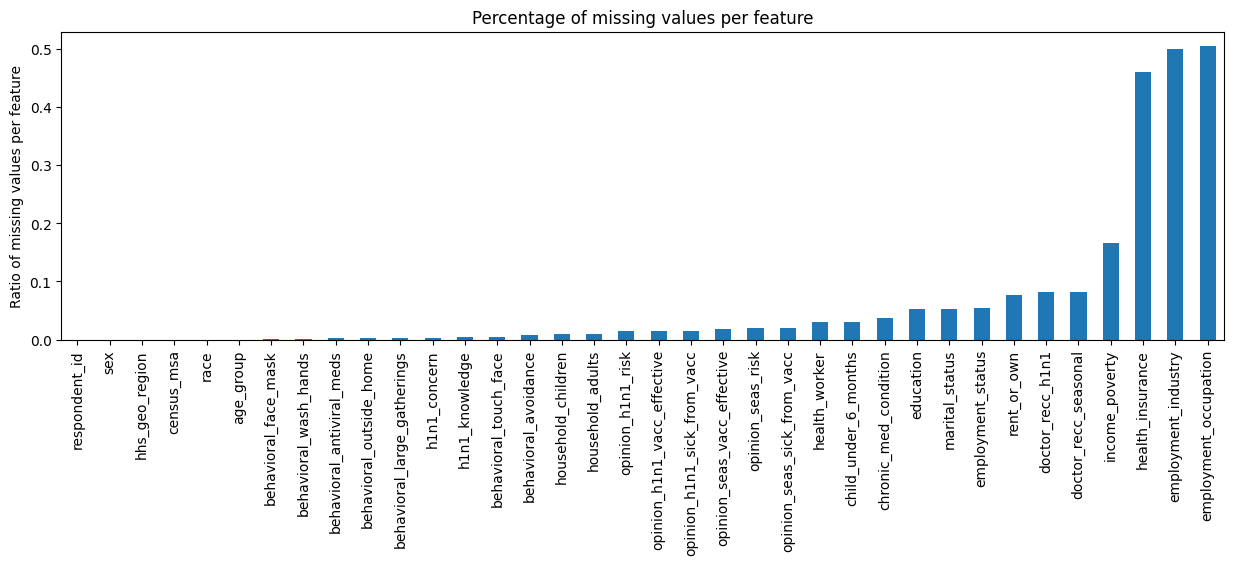

In [ ]:
features.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature")
plt.show()

Grafik yang disajikan menunjukkan jumlah missing values pada setiap fitur dalam dataset. Dari grafik tersebut, terlihat bahwa terdapat tiga variabel, yaitu "health_insurance", "employment_industry", dan "employment_occupation" yang memiliki missing values dengan persentase yang sangat tinggi, masing-masing sebesar 45,96%, 49,91%, dan 50,44%.

Treatment yang diambil untuk menangani masalah missing values akan dilakukan di bagian data preprocessing

<a id="2.3"></a>
### 2.3 Unwanted entries and recording errors
Another source of quality issues in a dataset can be due to unwanted entries or recording errors. It’s important to distinguish such samples from simple outliers. While outliers are data points that are unusual for a given feature distribution, unwanted entries or recording errors are samples that shouldn’t be there in the first place.

#### 2.3.1 Numerical features

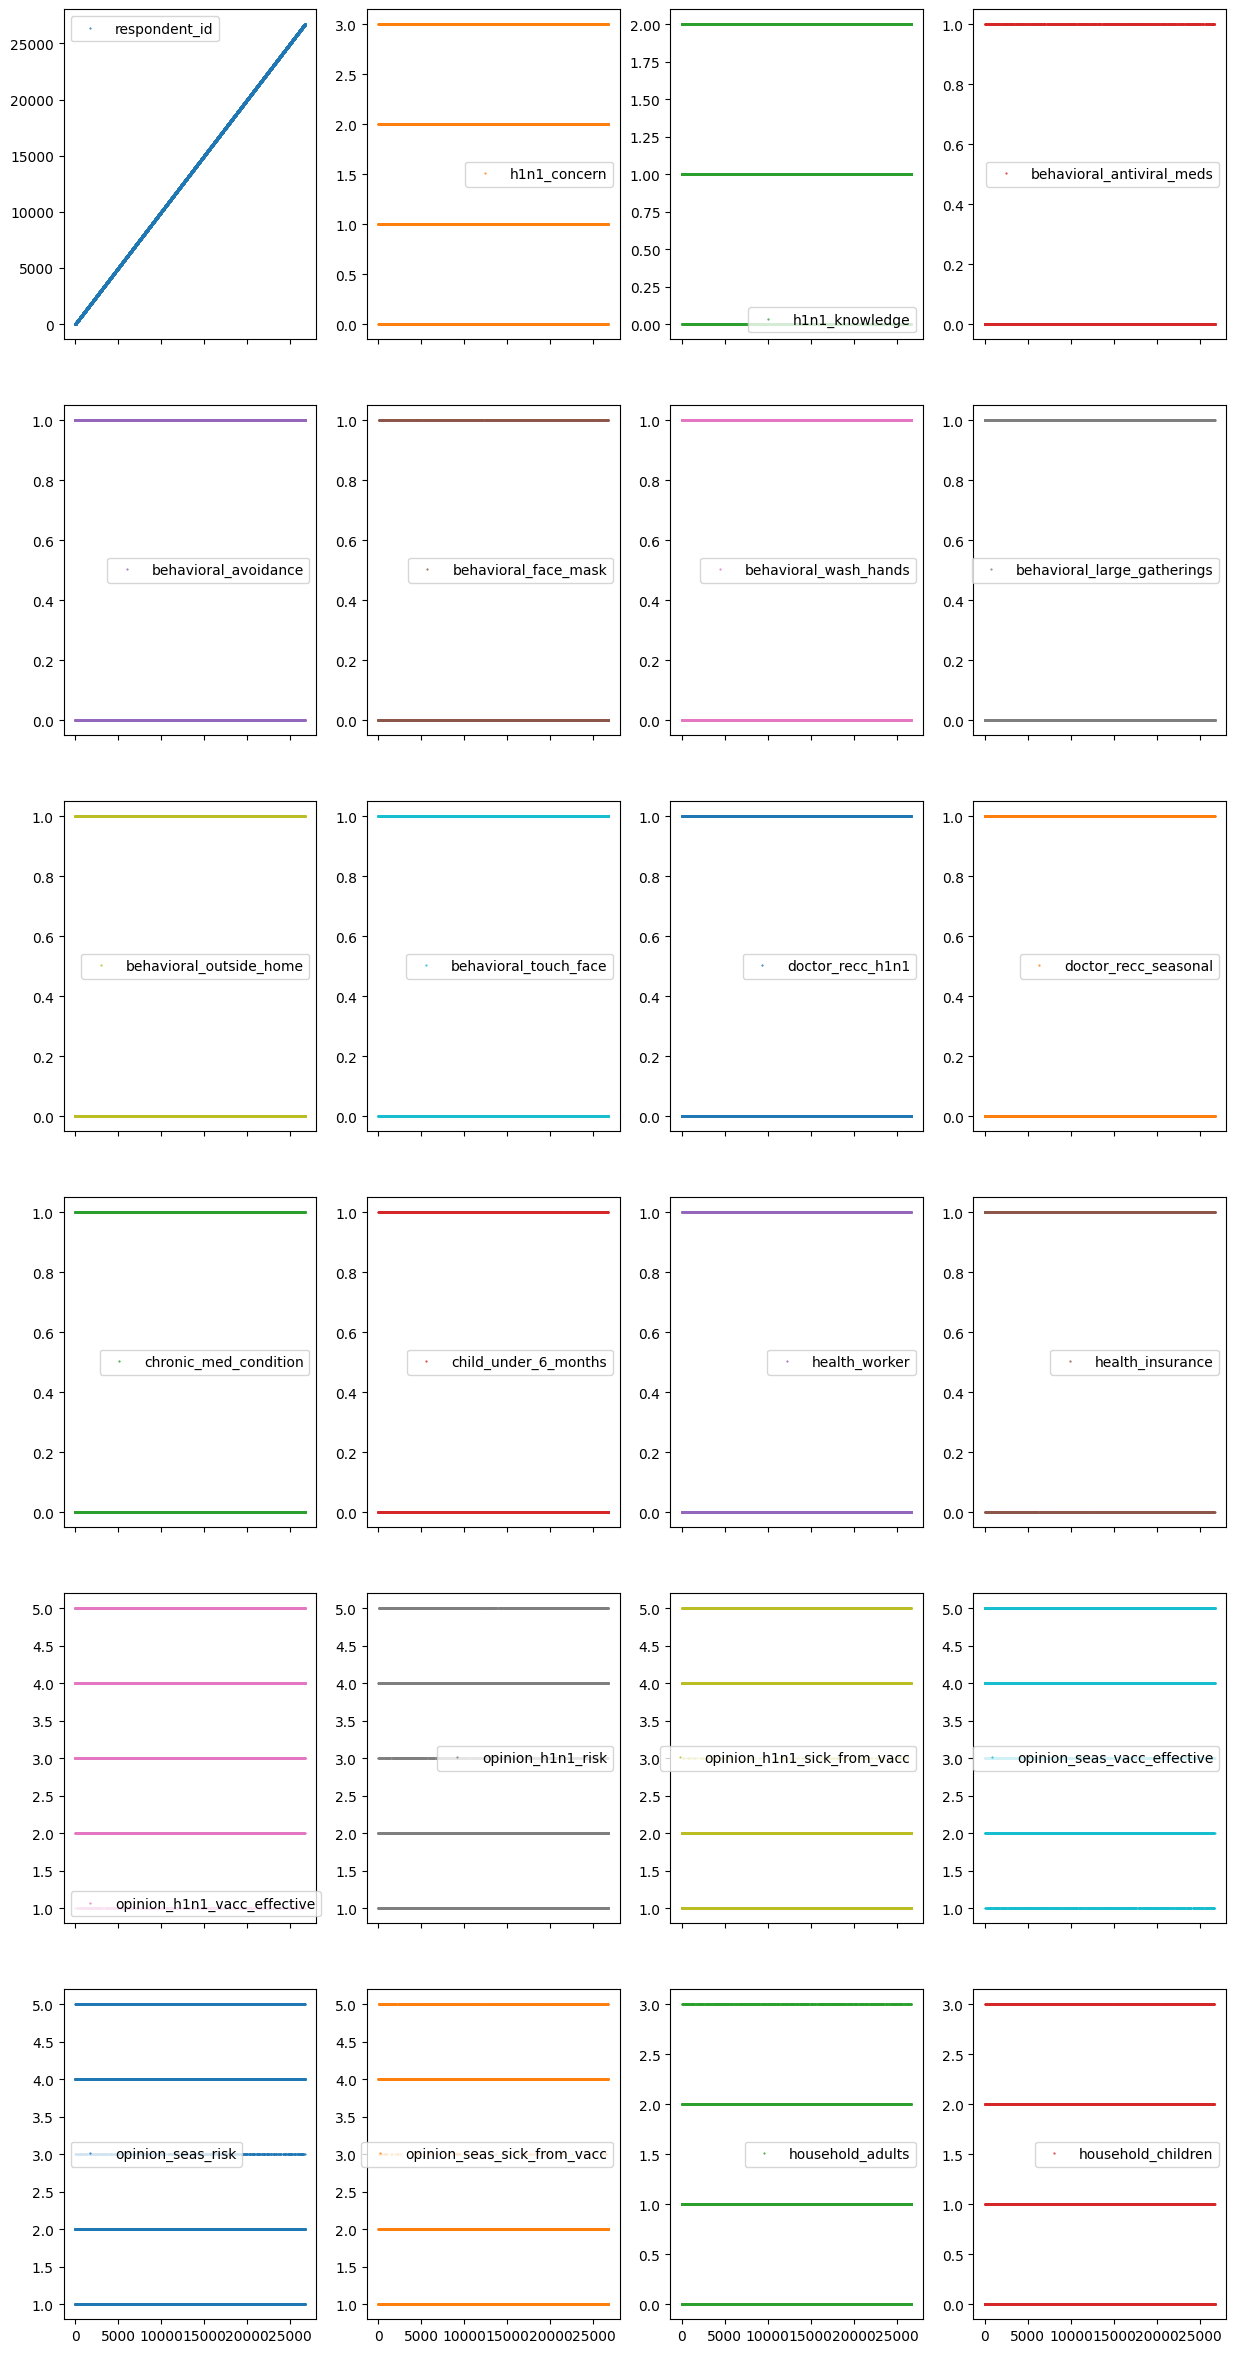

In [ ]:
features.plot(lw=0,
          marker=".",
          subplots=True,
          layout=(-1, 4),
          figsize=(15, 30),
          markersize=1);

Plot yang dihasilkan menunjukkan serangkaian scatter plot dengan setiap plot mewakili fitur numerik dalam dataset. Setiap titik pada plot mewakili sampel dalam dataset, dengan sumbu-x mewakili indeks sampel dan sumbu-y mewakili nilai fitur untuk sampel tersebut.

Setelah memeriksa semua plot, tampaknya data tersebut konsisten dan tidak ada entri anomali atau salah dalam dataset. Selain itu, terlihat bahwa data tersebut diskrit dan tidak mengandung outlier.

#### 2.3.2 Non-numerical features
We only want to investigate the general quality of the dataset. So what we can do is take a general look at how many unique values each of these non-numerical features contain, and how often their most frequent category is represented.

In [ ]:
features.describe(exclude=["number", "datetime"])

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


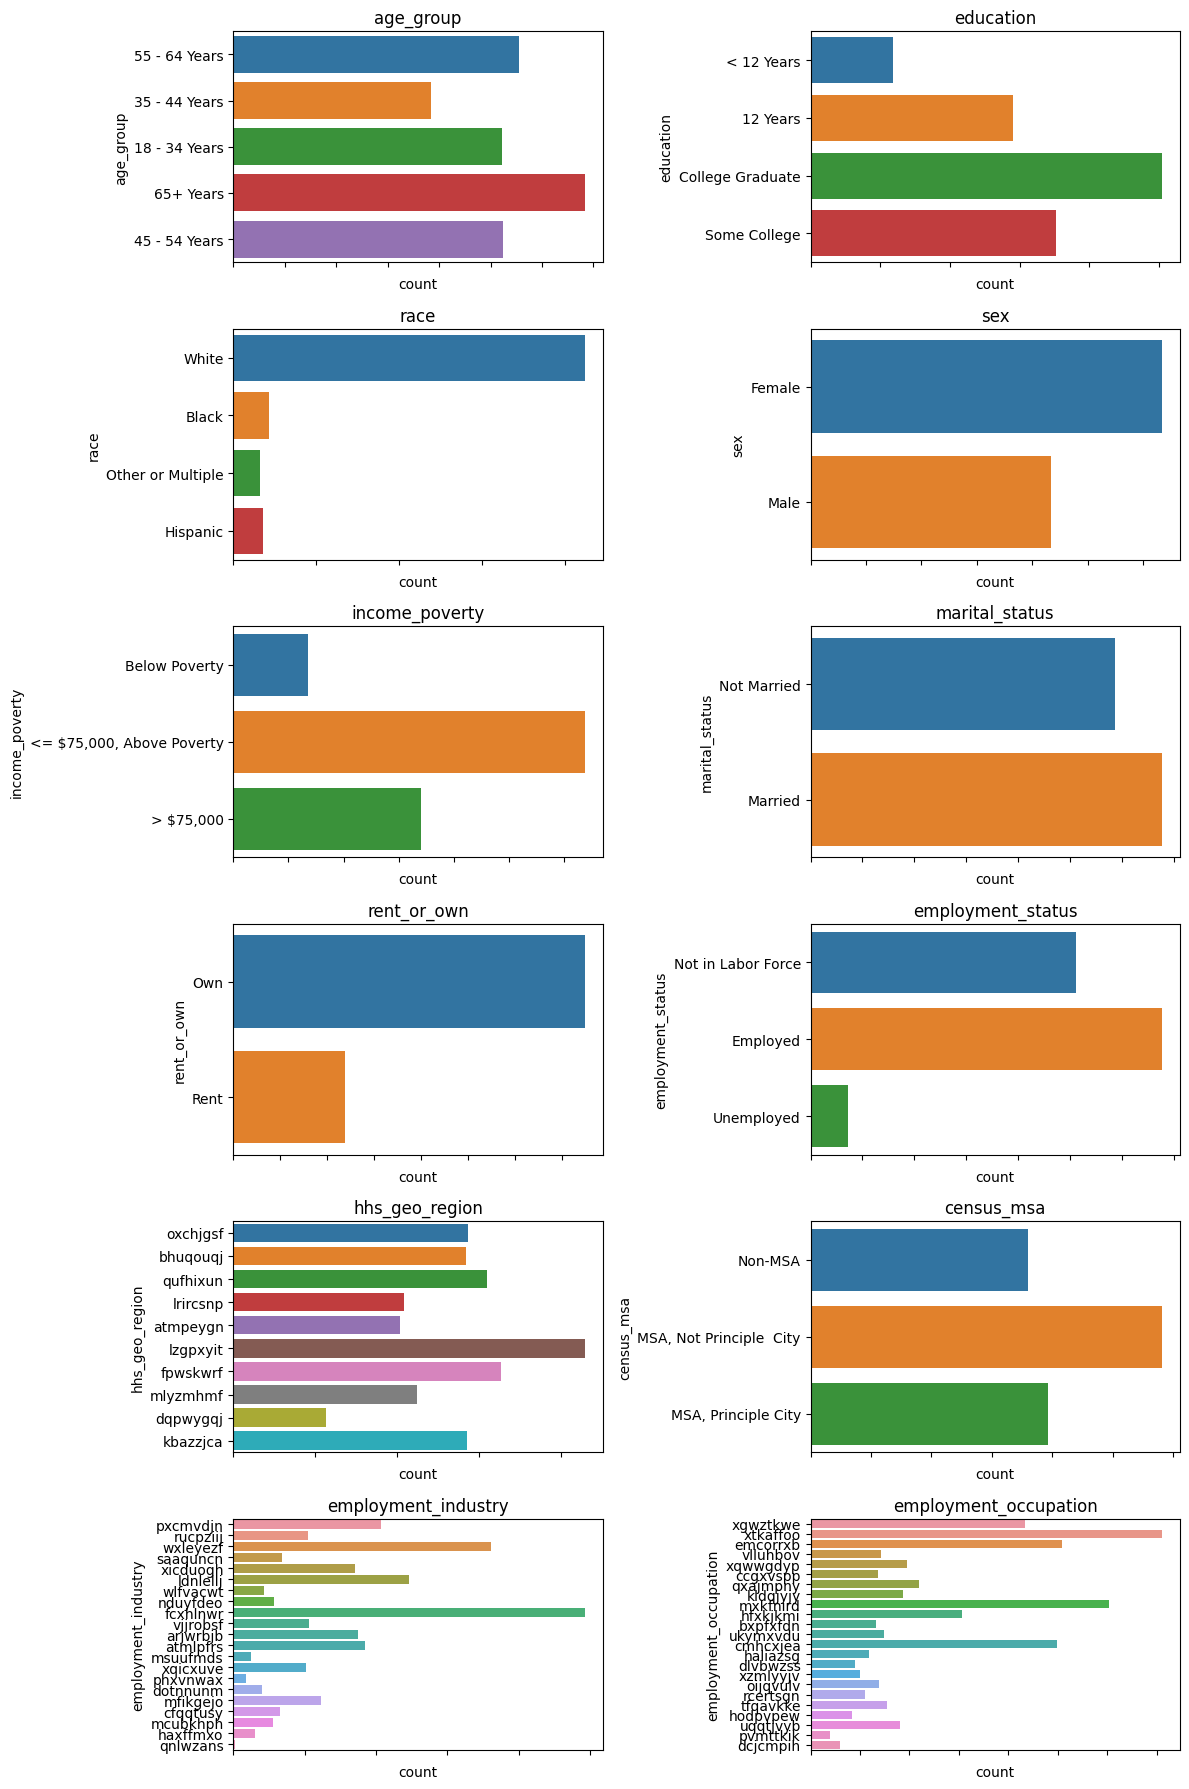

In [ ]:
# Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=2, nrows=6, figsize=(12, 18))

# Identify non-numerical features
df_non_numerical = features.select_dtypes(exclude=["number", "datetime"])

# Loop through features and put each subplot on a seaborn axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Plot countplot of the feature with seaborn
    sns.countplot(y=col, data=df_non_numerical, ax=ax)

    # Set title for each subplot
    ax.set_title(col)
    
    ax.set_xticklabels([])
    
plt.tight_layout();

Setelah memeriksa informasi dari setiap variabel, tidak terlihat adanya entri anomali atau salah dalam dataset. Selain itu, tidak terlihat adanya inkonsistensi pada data

<a id="3"></a>
## 3. Content investigation
Setelah memahami struktur dan kualitas dataset, kita dapat melakukan eksplorasi data yang lebih dalam dan melihat bagaimana nilai fitur-fiturnya saling berhubungan.

Untuk memudahkan investigasi data, kita akan menggabungkan 2 variabel target menjadi 1, sehingga diperoleh variabel target baru dengan kategori berikut:
- Did not receive both
- Received H1N1 vaccine
- Received seasonal vaccine
- Received both

In [ ]:
train = pd.concat([features, labels.drop('respondent_id', axis=1)], axis=1)

# membuat kolom baru
train['vaccine_received'] = 'did not receive both'

# mengganti nilai pada kolom baru berdasarkan nilai pada kolom 'h1n1_vaccine' dan 'seasonal_vaccine'
train.loc[(train['h1n1_vaccine'] == 1) & (train['seasonal_vaccine'] == 1), 'vaccine_received'] = 'received both'
train.loc[(train['h1n1_vaccine'] == 1) & (train['seasonal_vaccine'] == 0), 'vaccine_received'] = 'received h1n1 vaccine'
train.loc[(train['h1n1_vaccine'] == 0) & (train['seasonal_vaccine'] == 1), 'vaccine_received'] = 'received seasonal vaccine'

In [ ]:
col_to_vis = [col for col in train.select_dtypes(include='number').columns if col not in ["h1n1_vaccine", "seasonal_vaccine", "respondent_id"]]
hue_order = ['did not receive both', 'received seasonal vaccine', 'received h1n1 vaccine', 'received both']
def plot_hist(train, col_index, fig_size, subplot=[2, 5]):
    col_to_vis = [col for col in train.select_dtypes(include='number').columns if col not in ["h1n1_vaccine", "seasonal_vaccine", "respondent_id"]]
    col_to_vis = [col_to_vis[i] for i in col_index]
    plt.figure(figsize=fig_size)
    for i in range(len(col_to_vis)):
        plt.subplot(subplot[0], subplot[1], i+1)
        sns.histplot(data=train, x=col_to_vis[i], hue='vaccine_received', 
                     multiple="stack", legend=False, discrete=True, hue_order=hue_order)
        plt.ylabel('')
    plt.tight_layout()
    plt.show()

<a id="3.1"></a>
### 3.1 Feature Distribution

Di sini, kita akan mengelompokkan fitur-fitur numerik menjadi beberapa kelompok, yaitu:

1. **Fitur Perilaku Masyarakat**: `h1n1_concern`, `h1n1_knowledge`, `behavioral_antiviral_meds`, `behavioral_avoidance`, `behavioral_face_mask`, `behavioral_wash_hands`, `behavioral_large_gatherings`, `behavioral_outside_home`, `behavioral_touch_face`
2. **Fitur Rekomendasi Dokter**: `doctor_recc_h1n1`, `doctor_recc_seasonal`
3. **Fitur Informasi Medis**: `chronic_med_condition`, `child_under_6_months`, `health_worker`, `health_insurance`
4. **Fitur Opini Publik**: `opinion_h1n1_vacc_effective`, `opinion_h1n1_risk`, `opinion_h1n1_sick_from_vacc`, `opinion_seas_vacc_effective`, `opinion_seas_risk`, `opinion_seas_sick_from_vacc`
5. **Fitur Karakteristik Rumah Tangga**: `household_adults`, `household_children`

Kita akan memvisualisasikan distribusi setiap fitur numerik menggunakan histogram dengan menggunakan hue vaccine received agar kita dapat membandingkan distribusinya berdasarkan variabel target yaitu keputusan seseorang untuk menerima atau tidak menerima vaksin.

#### 3.1.1 Distribusi Fitur Perilaku Masyarakat

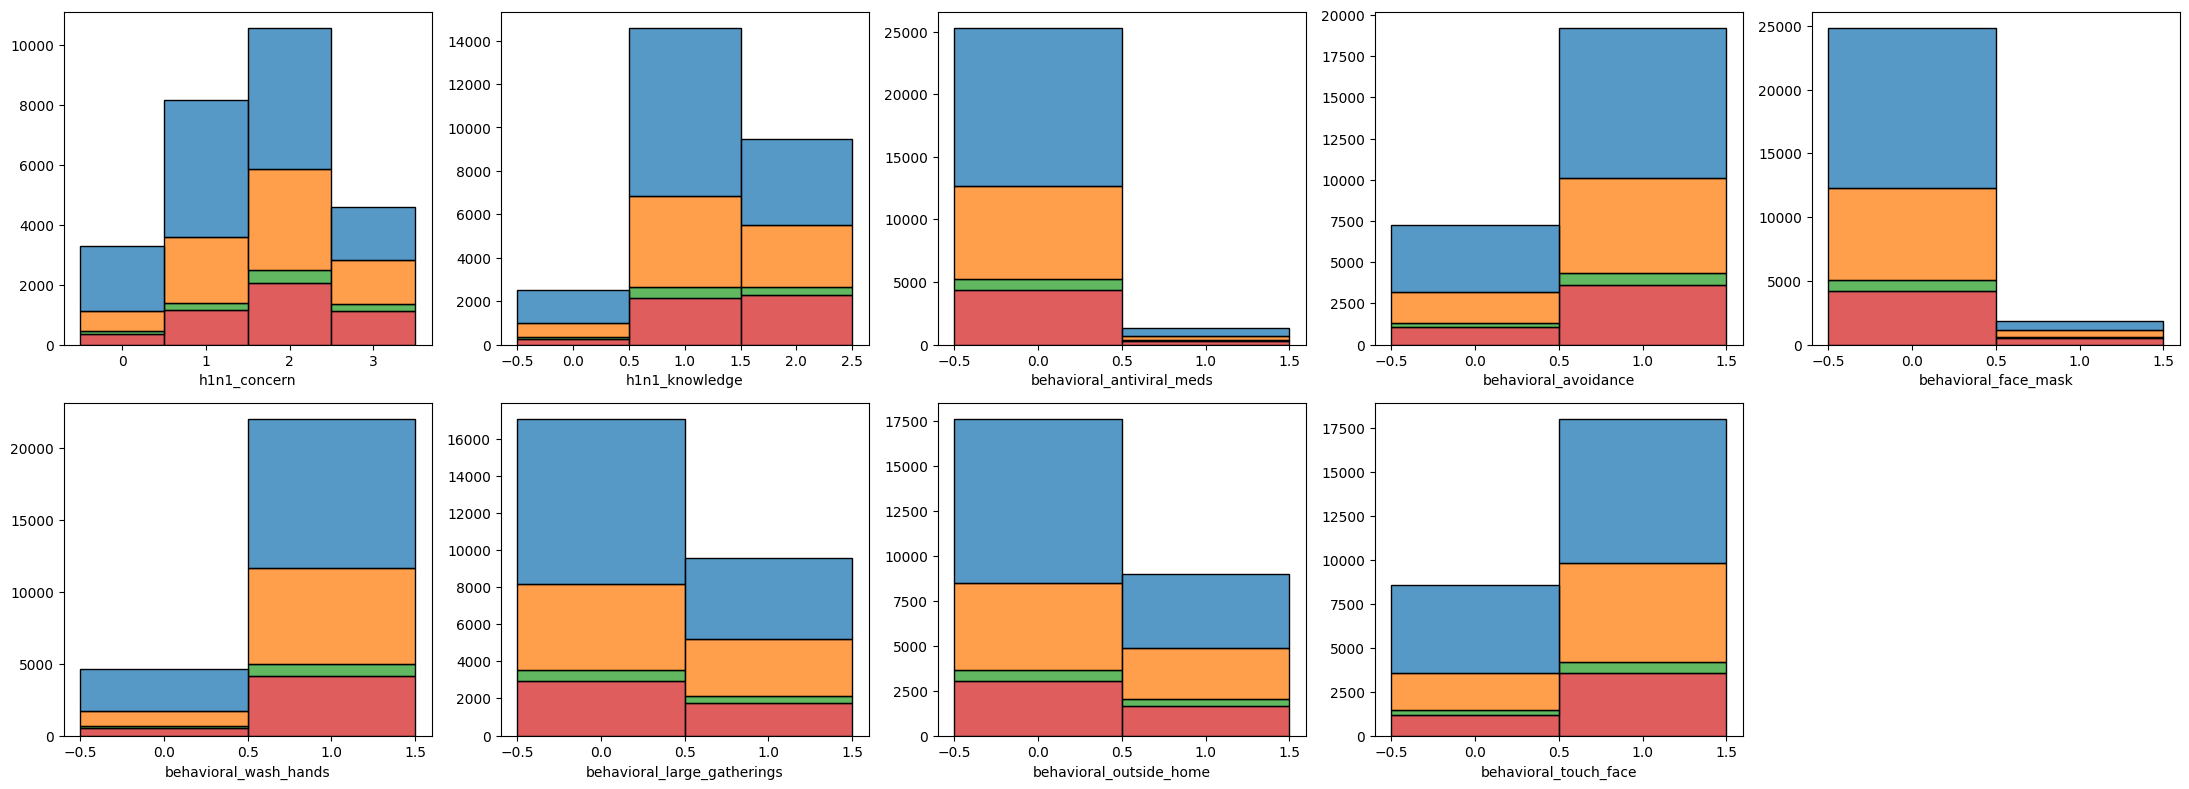

In [ ]:
col_index = [i for i in range(9)]
plot_hist(train, col_index, fig_size=(22, 8))

<span style="color:blue">Blue</span> : did not receive both&emsp;&emsp;<span style="color:orange">Orange</span> : received seasonal vaccine

<span style="color:green">Green</span> : received h1n1 vaccine&emsp;&emsp;<span style="color:red">Red</span> : received both

In [ ]:
for col in col_to_vis[:9]:
    group_counts = train.groupby([col, 'vaccine_received']).size().reset_index(name='counts')
    print(f'Data for {col}:')
    print(group_counts)
    print("---"*20)

Data menunjukkan adanya hubungan antara perilaku masyarakat dalam menghindari penyebaran virus dengan penerimaan vaksin. Orang-orang yang cenderung menghindari perilaku yang dapat menyebarkan virus cenderung lebih terbuka untuk menerima vaksin, baik itu vaksin H1N1 atau seasonal. Sebagai contoh, dari orang-orang yang cenderung tidak keluar rumah, sekitar 54% dari mereka yang menerima minimal salah satu vaksin H1N1 atau seasonal. Namun, dari mereka yang cenderung tidak memakai masker wajah, hanya sekitar 49% dari mereka yang menerima minimal salah satu vaksin H1N1 atau seasonal. Meskipun **tidak signifikan**, data ini menunjukkan bahwa perilaku masyarakat dalam menghindari penyebaran virus dan penerimaan vaksin saling berkaitan.

#### 3.1.2 Distribusi Fitur Rekomendasi Dokter

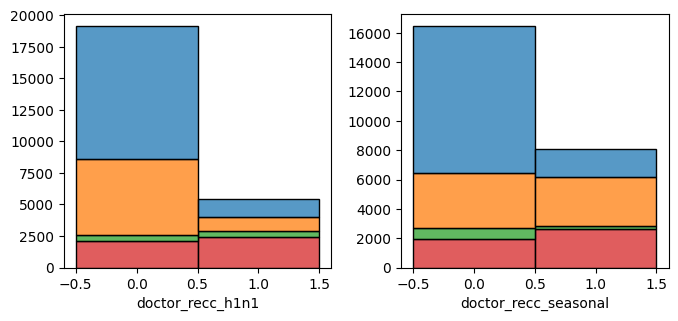

In [ ]:
col_index = [i for i in range(9, 11)]
plot_hist(train, col_index, fig_size=(17, 6))

<span style="color:blue">Blue</span> : did not receive both&emsp;&emsp;<span style="color:orange">Orange</span> : received seasonal vaccine

<span style="color:green">Green</span> : received h1n1 vaccine&emsp;&emsp;<span style="color:red">Red</span> : received both

In [ ]:
for col in col_to_vis[9:11]:
    group_counts = train.groupby([col, 'vaccine_received']).size().reset_index(name='counts')
    print(f'Data for {col}:')
    print(group_counts)
    print("---"*20)

Data menunjukkan bahwa rekomendasi dokter memiliki pengaruh besar terhadap keputusan seseorang untuk menerima vaksin. Dari orang-orang yang tidak menerima rekomendasi dokter untuk vaksinasi H1N1, sekitar 43% dari mereka yang menerima minimal salah satu vaksin H1N1 atau seasonal, sedangkan dari orang-orang yang menerima rekomendasi dokter untuk vaksinasi H1N1, sekitar 74% dari mereka yang menerima minimal salah satu vaksin. Hal yang sama terjadi untuk rekomendasi vaksinasi seasonal, di mana hanya sekitar 39% dari orang-orang yang tidak menerima rekomendasi dokter untuk vaksinasi seasonal yang menerima minimal salah satu vaksin H1N1 atau seasonal, sedangkan sekitar 74% dari orang-orang yang menerima rekomendasi dokter untuk vaksinasi seasonal yang menerima minimal salah satu vaksin. **Kesimpulannya, rekomendasi dokter menjadi faktor penting dalam menentukan penerimaan vaksin oleh masyarakat.**

#### 3.1.3 Distribusi Fitur Informasi Medis

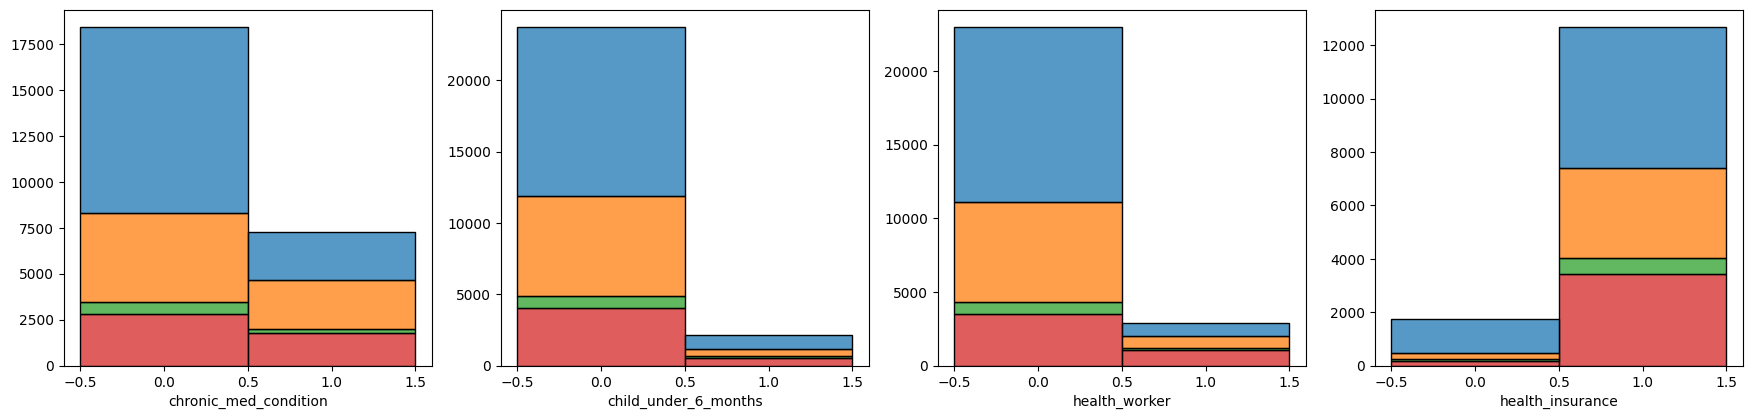

In [ ]:
col_index = [i for i in range(11, 15)]
plot_hist(train, col_index, fig_size=(22, 8))

<span style="color:blue">Blue</span> : did not receive both&emsp;&emsp;<span style="color:orange">Orange</span> : received seasonal vaccine

<span style="color:green">Green</span> : received h1n1 vaccine&emsp;&emsp;<span style="color:red">Red</span> : received both

In [ ]:
for col in col_to_vis[11:15]:
    group_counts = train.groupby([col, 'vaccine_received']).size().reset_index(name='counts')
    print(f'Data for {col}:')
    print(group_counts)
    print("---"*20)

Data tersebut merupakan informasi medis mengenai kondisi medis kronis, kontak dengan anak di bawah usia 6 bulan, pekerja kesehatan, dan asuransi kesehatan terkait penerimaan vaksin. Pada data kondisi medis kronis, 46.2% responden yang tidak memiliki kondisi medis kronis dan menerima minimal satu jenis vaksin, sedangkan 47.5% responden yang memiliki kondisi medis kronis dan menerima minimal satu jenis vaksin. 

Selanjutnya, 39.75% responden yang tidak sering bertemu anak di bawah 6 bulan dan menerima minimal satu jenis vaksin, sedangkan hanya 42.7% responden yang sering bertemu anak di bawah 6 bulan dan menerima minimal satu jenis vaksin. 

Pada data pekerja kesehatan, 49.6% responden yang bukan pekerja kesehatan dan menerima minimal satu jenis vaksin, sedangkan hanya 41.4% responden yang pekerja kesehatan dan menerimaminimal satu jenis vaksin. 

Pada data asuransi kesehatan, 22% responden yang tidak memiliki asuransi kesehatan dan menerima minimal satu jenis vaksin, sedangkan 58.5% responden yang memiliki asuransi kesehatan dan menerima minimal satu jenis vaksin.

Dari informasi tersebut, kita dapat menyimpulkan bahwa terdapat hubungan yang menarik pada variabel `health_insurance` dengan penerimaan vaksin. Karena **responden yang memiliki asuransi kesehatan cenderung lebih terbuka untuk menerima vaksin daripada responden yang tidak memiliki asuransi kesehatan**. Untuk variabel lainnya, tidak terlihat hubungan yang jelas dengan penerimaan vaksin

#### 3.1.4 Distribusi Fitur Opini Publik

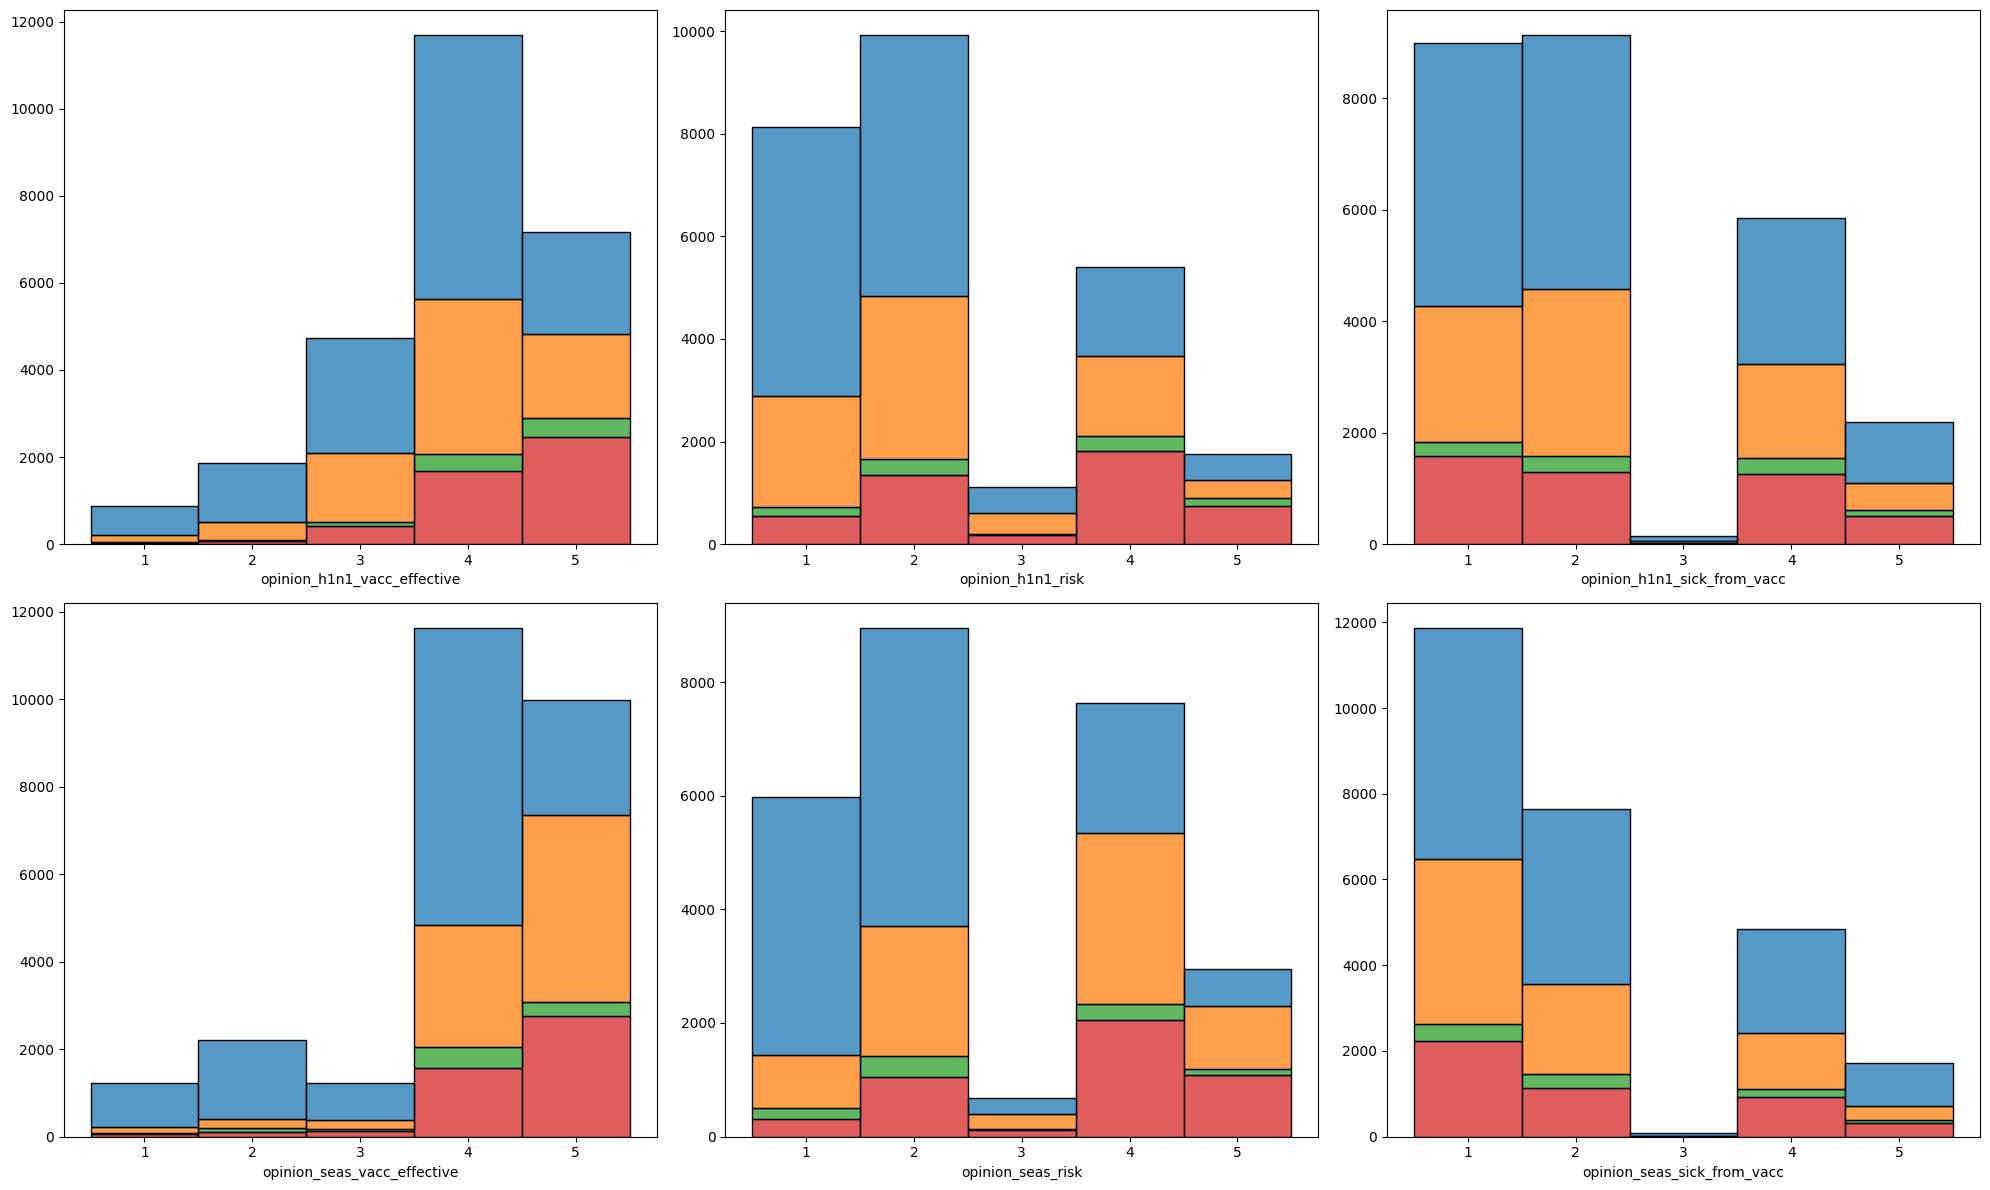

In [ ]:
col_index = [i for i in range(15, 21)]
plot_hist(train, col_index, fig_size=(20, 12), subplot=[2, 3])

<span style="color:blue">Blue</span> : did not receive both&emsp;&emsp;<span style="color:orange">Orange</span> : received seasonal vaccine

<span style="color:green">Green</span> : received h1n1 vaccine&emsp;&emsp;<span style="color:red">Red</span> : received both

In [ ]:
for col in col_to_vis[15:21]:
    group_counts = train.groupby([col, 'vaccine_received']).size().reset_index(name='counts')
    print(f'Data for {col}:')
    print(group_counts)
    print("---"*20)

Dari output di atas, dapat disimpulkan bahwa mayoritas responden yang tidak menerima vaksin baik H1N1 maupun flu musiman cenderung memiliki pandangan negatif terhadap efektivitas vaksin. Namun, semakin banyak responden yang menerima vaksin, semakin positif pandangan mereka terhadap efektivitas vaksin. Selain itu, mayoritas responden cenderung tidak merasa sakit setelah divaksinasi, terlepas dari jenis vaksin yang mereka terima. Pandangan terhadap risiko infeksi H1N1 pada umumnya tidak bervariasi secara signifikan berdasarkan status vaksinasi, meskipun responden yang menerima vaksin cenderung memiliki pandangan yang sedikit lebih positif.



#### 3.1.5 Distribusi Fitur Karakteristik Rumah Tangga

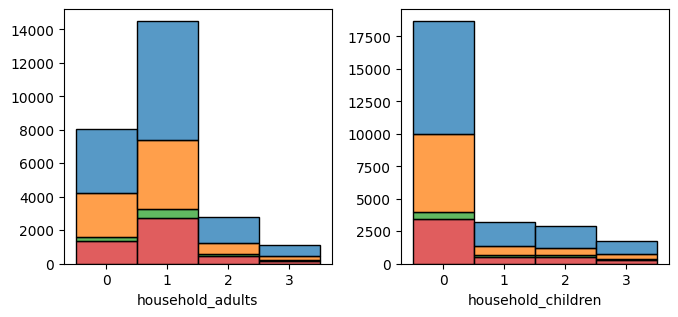

In [ ]:
col_index = [i for i in range(21, 23)]
plot_hist(train, col_index, fig_size=(17, 6))

<span style="color:blue">Blue</span> : did not receive both&emsp;&emsp;<span style="color:orange">Orange</span> : received seasonal vaccine

<span style="color:green">Green</span> : received h1n1 vaccine&emsp;&emsp;<span style="color:red">Red</span> : received both

In [ ]:
for col in col_to_vis[21:]:
    group_counts = train.groupby([col, 'vaccine_received']).size().reset_index(name='counts')
    print(f'Data for {col}:')
    print(group_counts)
    print("---"*20)

Berdasarkan data, tidak terlihat hubungan yang jelas antara karakteristik rumah tangga dengan keputusan seseorang untuk menerima vaksin. Jumlah orang dewasa dalam rumah tangga tidak memiliki pengaruh yang signifikan pada keputusan vaksinasi, karena jumlah responden yang menerima atau tidak menerima vaksin relatif sama di setiap kategori jumlah orang dewasa. Hal yang sama juga berlaku untuk jumlah anak-anak dalam rumah tangga. Jadi, dapat disimpulkan bahwa tidak ada hubungan yang signifikan antara karakteristik rumah tangga dengan keputusan seseorang untuk menerima vaksin.

#### 3.1.6 Fitur non-numerik

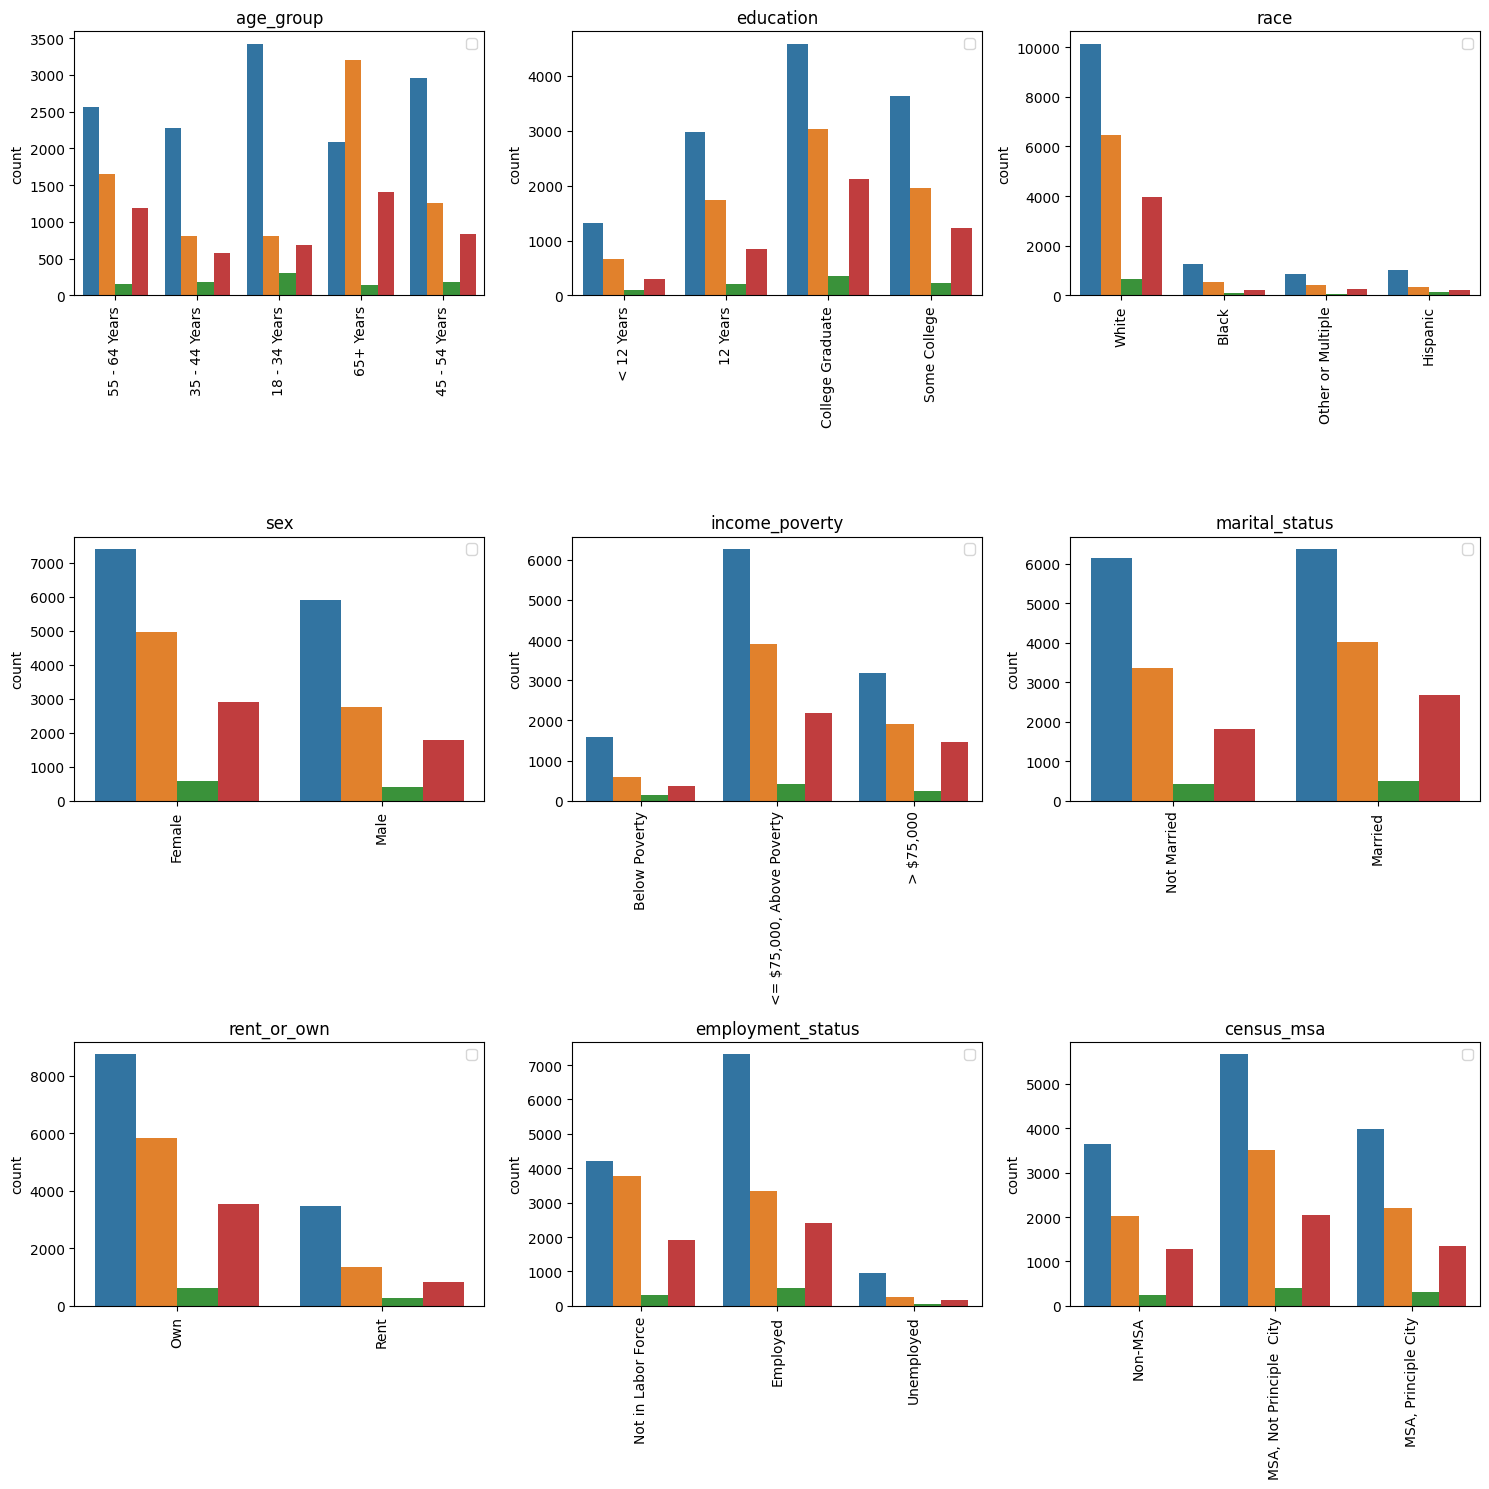

In [ ]:
col_to_vis = train.select_dtypes(include="O").drop(["hhs_geo_region", "employment_industry", "employment_occupation", "vaccine_received"], axis=1).columns
plt.figure(figsize=(15, 15))
hue_order = ['did not receive both', 'received seasonal vaccine', 'received h1n1 vaccine', 'received both']
for i in range(9):
    plt.subplot(3, 3, i+1)
    sns.countplot(data = train, x=col_to_vis[i], hue='vaccine_received', hue_order=hue_order)
    plt.legend('')
    plt.xticks(rotation=90)
    plt.title(col_to_vis[i])
    plt.xlabel('')
plt.tight_layout()
plt.show()

<span style="color:blue">Blue</span> : did not receive both&emsp;&emsp;<span style="color:orange">Orange</span> : received seasonal vaccine

<span style="color:green">Green</span> : received h1n1 vaccine&emsp;&emsp;<span style="color:red">Red</span> : received both

Tampaknya beberapa faktor seperti tingkat pendidikan, ras, jenis kelamin, tingkat kemiskinan pendapatan, status perkawinan, status kepemilikan rumah, status pekerjaan, dan wilayah statistik metropolitan sensus (MSA) semuanya menunjukkan hubungan dengan vaksinasi h1n1 dan seasonal.

Secara umum, individu dengan tingkat pendidikan dan pendapatan yang lebih tinggi lebih cenderung untuk menerima vaksinasi. Perempuan juga lebih cenderung untuk menerima vaksinasi dibandingkan laki-laki. Individu yang menikah dan memiliki rumah sendiri memiliki tingkat vaksinasi yang lebih tinggi dibandingkan dengan individu yang tidak menikah atau menyewa. Status pekerjaan juga terkait dengan tingkat vaksinasi yang lebih tinggi, dengan individu yang bekerja lebih cenderung untuk menerima vaksinasi dibandingkan dengan individu yang tidak bekerja.

<a id="3.2"></a>
### 3.2 Correlation
Can we identify particular relationships between variables that will help us to better understand our dataset?

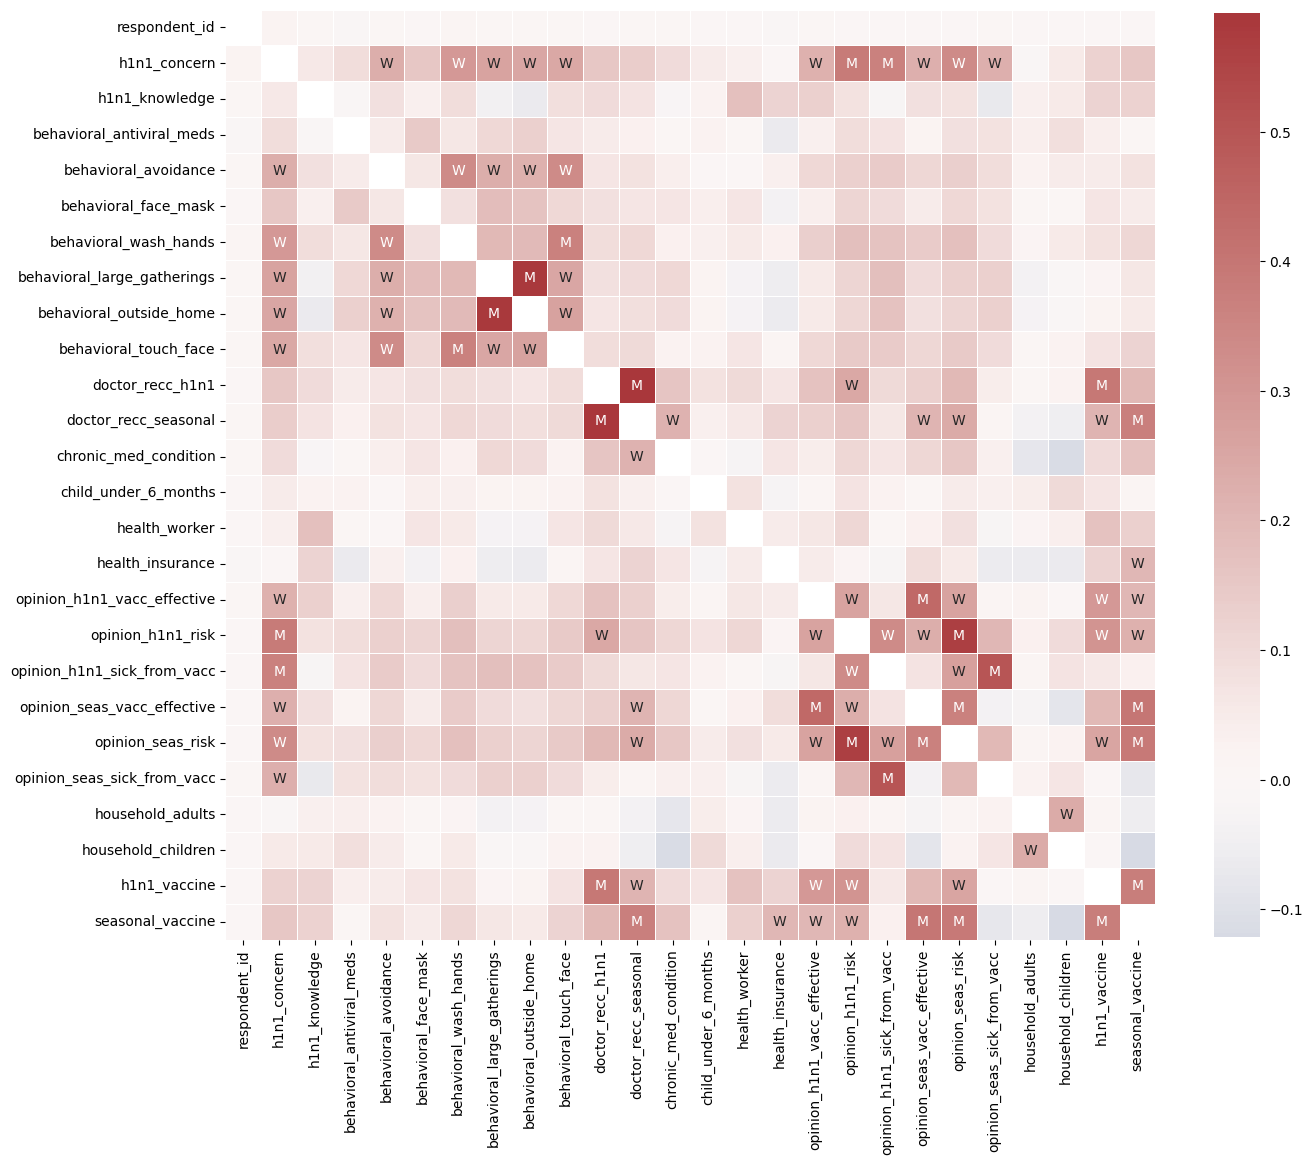

In [ ]:
# Computes feature correlation
df_corr = train.corr(method="spearman", numeric_only=True)

# Create labels for the correlation matrix
lbls = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.35, "M",
                           np.where(np.abs(df_corr)>0.20, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=lbls, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

In [ ]:
# Computes feature correlation
df_corr = pd.get_dummies(train.drop('vaccine_received', axis=1)).corr(method="spearman", numeric_only=False)
print(df_corr[["h1n1_vaccine", "seasonal_vaccine"]].sort_values("h1n1_vaccine", ascending=False).head(10))

                              h1n1_vaccine  seasonal_vaccine
h1n1_vaccine                      1.000000          0.377143
doctor_recc_h1n1                  0.393890          0.198607
seasonal_vaccine                  0.377143          1.000000
opinion_h1n1_risk                 0.305840          0.219161
opinion_h1n1_vacc_effective       0.291602          0.201753
opinion_seas_risk                 0.256199          0.389286
doctor_recc_seasonal              0.209864          0.369190
opinion_seas_vacc_effective       0.195961          0.397874
health_worker                     0.169768          0.127311
employment_industry_fcxhlnwr      0.144660          0.110386


Berdasarkan hasil yang ditampilkan sebelumnya, variabel `h1n1_vaccine` memiliki korelasi positif yang kuat dengan variabel `doctor_recc_h1n1`, dengan nilai korelasi sebesar 0.393. Demikian pula, variabel `seasonal_vaccine` memiliki korelasi positif yang kuat dengan variabel `doctor_recc_seasonal`, dengan nilai korelasi sebesar 0.369.

Variabel opini publik seperti `opinion_h1n1_risk`, `opinion_h1n1_vacc_effective`, `opinion_seas_risk`, dan `opinion_seas_vacc_effective` memiliki korelasi positif sedang dengan variabel target, dengan nilai korelasi berkisar antara 0.195 hingga 0.305.

Secara keseluruhan, hasil ini menunjukkan bahwa rekomendasi dokter memiliki korelasi positif yang kuat dengan keputusan orang untuk menerima vaksinasi, sedangkan opini publik tentang risiko dan efektivitas vaksin memiliki korelasi positif sedang dengan keputusan tersebut.

<a id="prepro"></a>
# Preprocessing

In [ ]:
train = pd.read_csv("/content/training_set_features.csv", index_col = 'respondent_id')
test = pd.read_csv('/content/test_set_features.csv', index_col='respondent_id')
labels = pd.read_csv("/content/training_set_labels.csv", index_col = 'respondent_id')

<a id="imputation"></a>
## Data Imputation

Sebelum mengisi missing values, kami membagi data train menjadi 3 bagian berdasarkan tipe datanya yakni numerik sebagai num_cols, kategorik sebagai cat_cols, dan ordinal sebagai ord_cols. Pembagian ini bertujuan untuk mengevaluasi missing values lebih lanjut agar dapat memilih metode imputasi yang tepat.

In [ ]:
#Mengambil data numerik dari data train
num_cols = train.select_dtypes('number').columns
#Mengambil data kategorik dari data train
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']
#Mengambil data ordinal dari data train
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']
#Memastikan jumlah dari variabel num_cols, cat_cols, dan ord_cols sama dengan jumlah variabel dalam data train
assert len(num_cols)+len(cat_cols)+len(ord_cols) == train.shape[1]

In [ ]:
# Menampilkan kolom numerik apakah memiliki nilai negatif atau tidak
has_negative_values = (train[num_cols] < 0).any()
print(has_negative_values)

h1n1_concern                   False
h1n1_knowledge                 False
behavioral_antiviral_meds      False
behavioral_avoidance           False
behavioral_face_mask           False
behavioral_wash_hands          False
behavioral_large_gatherings    False
behavioral_outside_home        False
behavioral_touch_face          False
doctor_recc_h1n1               False
doctor_recc_seasonal           False
chronic_med_condition          False
child_under_6_months           False
health_worker                  False
health_insurance               False
opinion_h1n1_vacc_effective    False
opinion_h1n1_risk              False
opinion_h1n1_sick_from_vacc    False
opinion_seas_vacc_effective    False
opinion_seas_risk              False
opinion_seas_sick_from_vacc    False
household_adults               False
household_children             False
dtype: bool


In [ ]:
# Mengisi missing values pada kolom kategorik dan ordinal dengan 'None'
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='None')
    test[col] = test[col].fillna(value='None')

# Mengisi missing values pada kolom numerik dengan nilai -1
for col in num_cols:
    train[col] = train[col].fillna(value=-1)
    test[col] = test[col].fillna(value=-1)

Dalam proses imputasi, kita memasukkan nilai yang tidak terdapat pada dataset sehingga nilai missing values dapat diatasi secara konsisten oleh model yang dibuat nantinya. Pada analisis sebelumnya sudah diketahui bahwa tidak terdapat nilai negatif dalam data, sehingga dalam kasus ini missing values variabel numerik dan ordinal diisi dengan -1 dan missing values kategorik diisi dengan string "None".

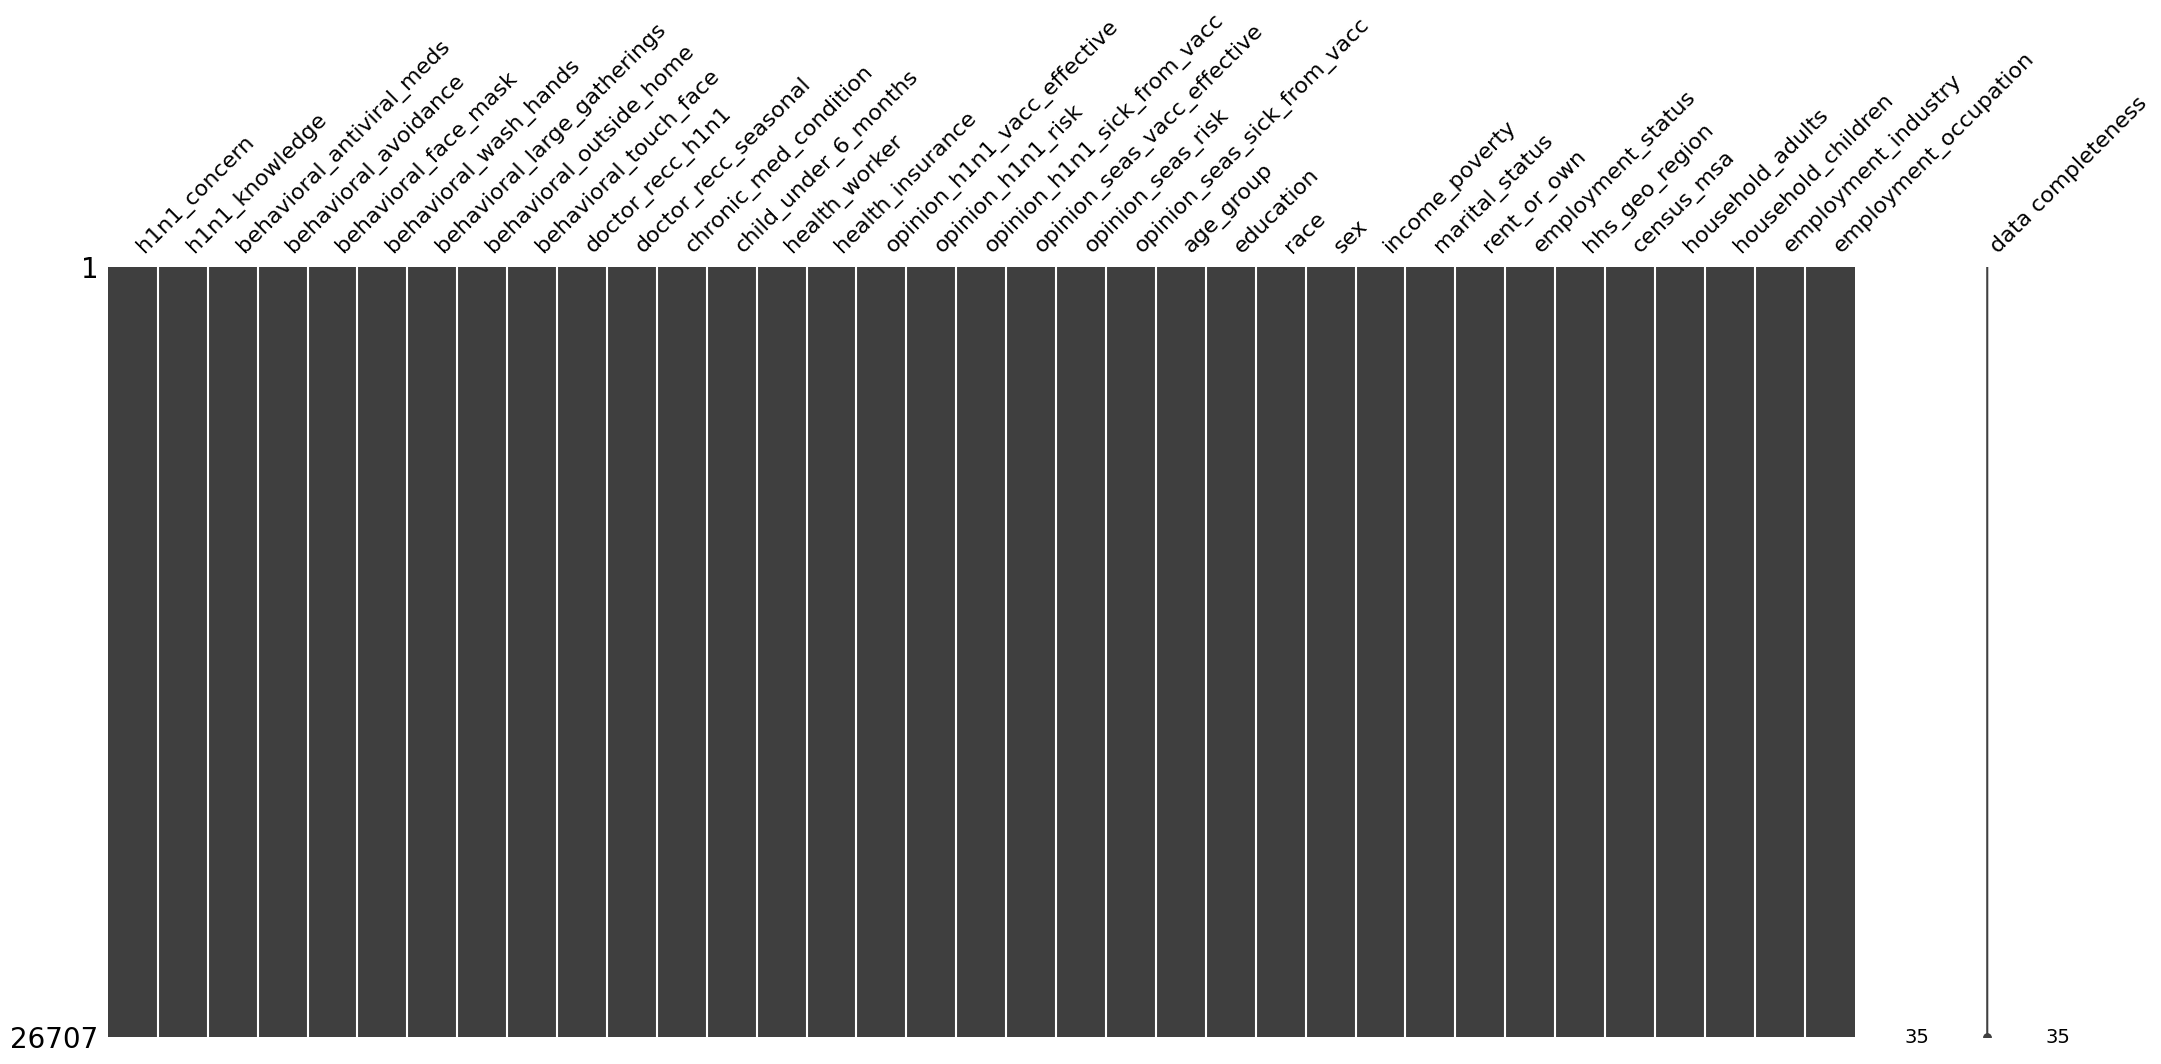

In [ ]:
msno.matrix(train, labels=True, sort="descending");

Melalui Visualisasi di atas, dapat diketahui bahwa semua missing values sudah terisi, sehingga data yang akan diproses sudah merupakan data yang bebas dari missing values.

<a id="partitioning"></a>
## Data Partitioning

Membagi dataset menjadi 2 bagian yakni training dan testing untuk mengevaluasi performa dari model. Data training digunakan untuk melatih model, sedangkan data testing digunakan untuk menguji performa model setelah dilatih. Data testing harus merupakan data yang sudah terlabel yang belum dipelajari oleh model, agar model dapat memprediksi data baru yang belum pernah dipelajari dan menghindari adanya data leakage.

In [ ]:
# Menggunakan random state 68 membagi data menjadi train dengan ukuran 0.7 dan test dengan ukuran 0.3 untuk dataframe train dan labels.
# Menjabarkan train sebagai variabel independen (x) dan labels sebagai variabel dependen (y)
X_train, X_test, y_train, y_test = train_test_split( train, labels, test_size=0.3, random_state=68)

<a id="encoding"></a>
## Encoding Categorical Data

In [ ]:
# Mengambil semua nama kolom yang memiliki tipe object/kategorik
cat_cols = X_train.select_dtypes('object').columns

In [ ]:
# Mentransformasi kolom-kolom pada dataset
ct = ColumnTransformer(
    [('ordinal', ohe(), cat_cols)], # mentransformasi cat_cols menjadi numerik dengan one hot encoding
    remainder='passthrough') # membiarkan kolom selain cat_cols tidak diubah nilainya

Dalam transformasi tersebut, data cat_cols diubah menjadi numerik dengan one hot encoding. Metode one hot encoding dipilih karena data kategorik secara default diprepocessing menggunakan one hot encoding dalam Catboost model. Data tersebut akan digunakan untuk dilanjutkan ke dalam proses feature selection

In [ ]:
# Mengambil semua nama kolom dari dataset X_train
all_cols = X_train.columns

<a id="fs"></a>
## Feature Selection

Feature selection merupakan suatu teknik dalam machine learning untuk memilih subset fitur (variabel) yang paling relevan untuk meningkatkan performa model. Faktor utama yang mendorong penggunaan teknik feature selection adalah untuk meningkatkan performa model, mengurangi dimensi data, meningkatkan kecepatan pelatihan model, dan meningkatkan interpretasi model.

Karena dalam kasus ini terdapat 2 variabel target, kami melakukan feature selection yang berbeda untuk memprediksi masing-masing variabel target.

### Feature Selection by `h1n1_vaccine`

In [ ]:
# Membuat objek SequentialFeatureSelector dari library mlxtend untuk melakukan seleksi fitur secara sekuensial
sfs2 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), # menggunakan catboost sebagai estimator feature selection
           k_features=X_train.shape[1], # menentukan jumlah fitur yang akan digunakan dalam dataset
           forward=True, # SequentialFeatureSelector akan memulai dengan satu fitur dan menambahkan satu per satu
           floating=False, # tidak menggunakan metode floating selection
           verbose=2, # menampilkan informasi selama proses seleksi fitur
           scoring='roc_auc', # menggunakan ROC AUC sebagai metrik evaluasi
           cv=5) # menggunakan cross validation dengan fold sebesar 5

In [ ]:
# Melakukan fitting objek SequentialFeatureSelector pada data train (X_train dan y_train.h1n1_vaccine)
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:  1.4min finished

[2023-05-11 08:06:19] Features: 1/35 -- score: 0.7071737862072726[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:  2.0min finished

[2023-05-11 08:08:21] Features: 2/35 -- score: 0.7867904926588798[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  2.3min finished

[2023-05-11 08:10:37] Features: 3/35 -- score: 0.8253150889609768[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [ ]:
# Membuat dataframe pandas dari dictionary yang dihasilkan oleh metode get_metric_dict() dari objek SequentialFeatureSelector (sfs2)
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(105,)","[0.7050372019814923, 0.708107924020672, 0.7061...",0.707174,"(105,)",0.005078,0.003951,0.001975
2,"(98, 105)","[0.7925673159437187, 0.7833433373349339, 0.783...",0.78679,"(98, 105)",0.008038,0.006254,0.003127
3,"(98, 103, 105)","[0.8313456200855761, 0.8251577226635334, 0.814...",0.825315,"(98, 103, 105)",0.00898,0.006987,0.003494
4,"(98, 103, 104, 105)","[0.847351505250716, 0.8445369637216589, 0.8370...",0.844031,"(98, 103, 104, 105)",0.007483,0.005822,0.002911
5,"(98, 102, 103, 104, 105)","[0.8518090534053597, 0.8495087396660792, 0.843...",0.850546,"(98, 102, 103, 104, 105)",0.008767,0.006821,0.003411
6,"(51, 98, 102, 103, 104, 105)","[0.8559862338607485, 0.8525320766604514, 0.846...",0.853962,"(51, 98, 102, 103, 104, 105)",0.007825,0.006088,0.003044
7,"(51, 90, 98, 102, 103, 104, 105)","[0.8590751785959289, 0.8536178301107678, 0.850...",0.855631,"(51, 90, 98, 102, 103, 104, 105)",0.008383,0.006522,0.003261
8,"(51, 90, 91, 98, 102, 103, 104, 105)","[0.8598176416900803, 0.8537236171064171, 0.852...",0.856996,"(51, 90, 91, 98, 102, 103, 104, 105)",0.008412,0.006545,0.003272
9,"(9, 51, 90, 91, 98, 102, 103, 104, 105)","[0.8608123504954157, 0.8539896809787744, 0.853...",0.857889,"(9, 51, 90, 91, 98, 102, 103, 104, 105)",0.008798,0.006845,0.003422
10,"(9, 46, 51, 90, 91, 98, 102, 103, 104, 105)","[0.8610763137016293, 0.854671868747499, 0.8547...",0.859074,"(9, 46, 51, 90, 91, 98, 102, 103, 104, 105)",0.007998,0.006222,0.003111


In [ ]:
# Menampilkan indeks fitur yang dipilih dalam subset fitur terbaik pada iterasi ke-19 (iterasi dengan hasil terbaik)
print(sfdf2.loc[19, 'feature_idx'])

(9, 13, 14, 20, 46, 51, 53, 89, 90, 91, 92, 98, 99, 102, 103, 104, 105, 106, 108)


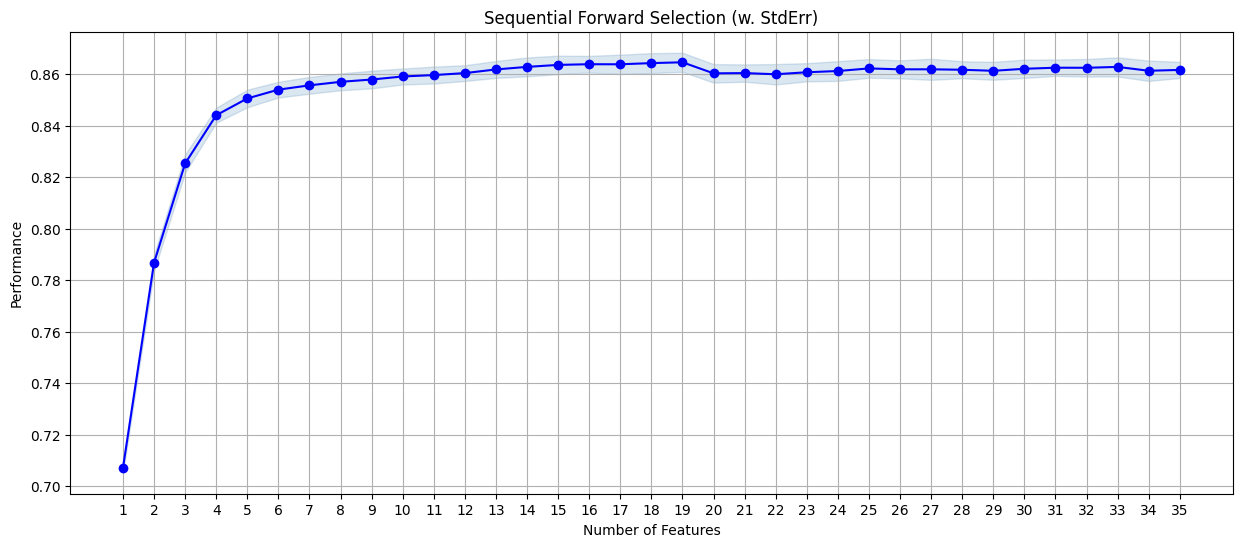

In [ ]:
# Menampilkan visualisasi dari performa model untuk setiap penggunaan featuresnya
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
# Menampilkan nama kolom hasil dari feature selection
selected_columns_h1 = [all_cols[i] for i in 
                     list((9, 13, 14, 20, 46, 51, 53, 89, 90, 91, 92, 98, 99, 102, 103, 104, 105, 106, 108))]
selected_columns_h1                     

['h1n1_concern',
 'behavioral_avoidance',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

### Feature Selection by `seasonal_vaccine`

In [ ]:
sfs3 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [ ]:
sfs3 = sfs3.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:  1.7min finished

[2023-05-11 11:20:26] Features: 1/35 -- score: 0.7149885991744259[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:  2.7min finished

[2023-05-11 11:23:09] Features: 2/35 -- score: 0.7756060728260028[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  3.3min finished

[2023-05-11 11:26:24] Features: 3/35 -- score: 0.8134458582502144[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [ ]:
sfdf3 = pd.DataFrame.from_dict(sfs3.get_metric_dict()).T
sfdf3

In [ ]:
print(sfdf3.loc[19, 'feature_idx'])

In [ ]:
fig = plot_sfs(sfs3.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
selected_columns_se = [all_cols[i] for i in 
                     list((0, 1, 4, 6, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32))]
selected_columns_se

# Data Modelling

**Mengoptimalkan menggunakan Optuna dan cross validation**

Menggunakan features terpilih pada feature selection yang dilakukan di observasi sebelumnya, tidak menghasilkan hasil yang lebih baik daripada menggunakan seluruh dataset. Hal ini dapat disebabkan oleh cara kerja model Catboost yang dapat mengatasi features yang kurang berpengaruh ataupun features yang tidak berguna.

Karena kasus ini merupakan multiclass classification, maka dibuat 2 model yang berbeda untuk memprediksi kelas dari h1n1_vaccine dan seasonal_vaccine. Hal tersebut digunakan untuk menciptakan model yang dapat memprediksi dengan lebih spesifik untuk masing-masing variabel targetnya. Hasil kedua prediksi tersebut kemudian akan digabung dan dievaluasi secara bersamaan.

Berikut merupakan pipeline yang kami gunakan untuk pemodelan data

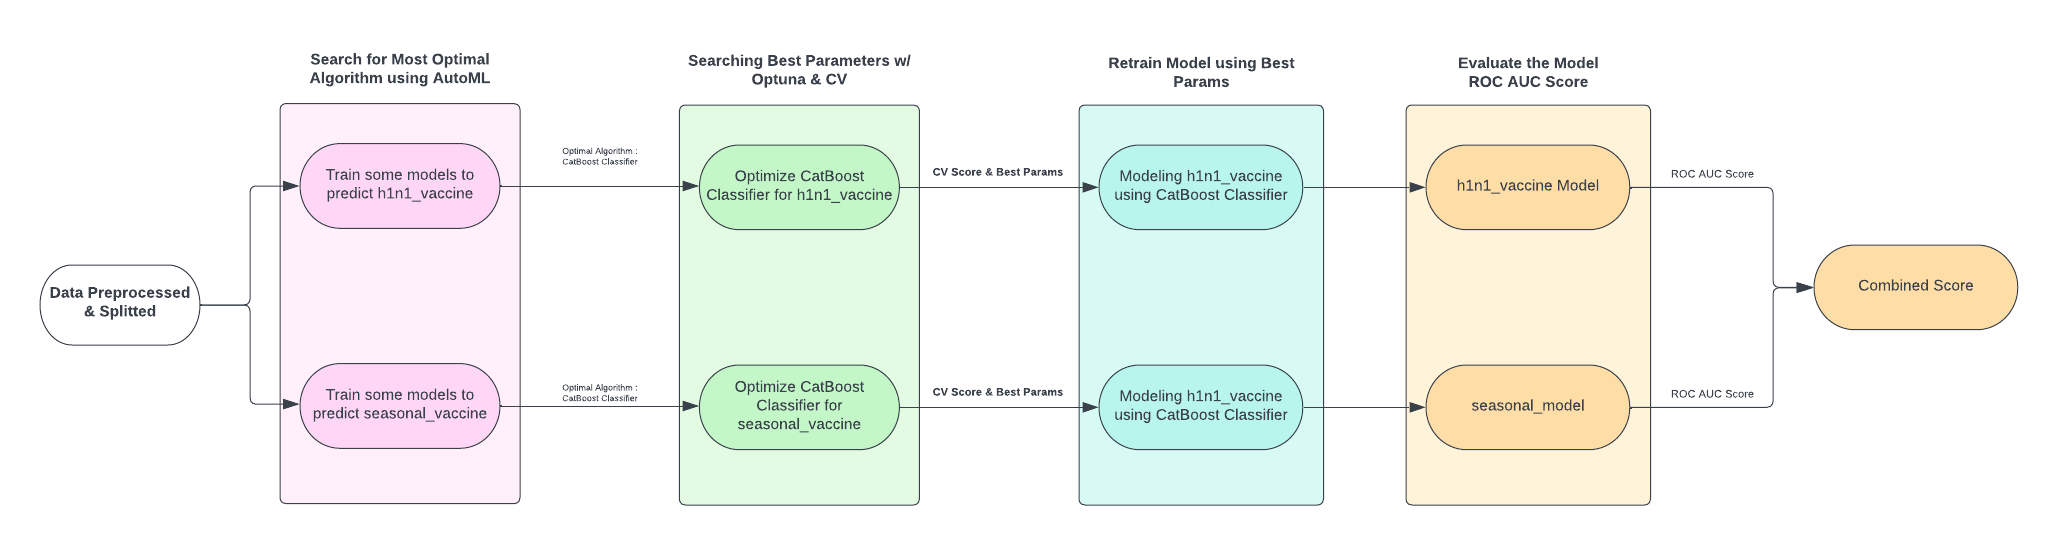

## Auto Machine learning

Menggunakan auto machine learning untuk mengetahui algoritma apa yang bekerja dengan baik pada data yang dimiliki.

In [ ]:
# Melakukan penggabungan data train dan labels berdasarkan respondent_id
train_merged = pd.merge(train, labels, on = 'respondent_id')

### Model Prediksi h1n1_vaccine

In [ ]:
from pycaret.classification import *
# Melakukan set up utuk modelig regresi
exp_h1n1 = setup(data = train_merged,  target = 'h1n1_vaccine', ignore_features = ["respondent_id", "seasonal_vaccine", 'employment_industry','employment_occupation'])

,Description,Value
0,Session id,7768
1,Target,h1n1_vaccine
2,Target type,Binary
3,Original data shape,"(26707, 37)"
4,Transformed data shape,"(26707, 66)"
5,Transformed train set shape,"(18694, 66)"
6,Transformed test set shape,"(8013, 66)"
7,Ignore features,4
8,Ordinal features,1
9,Numeric features,23


In [ ]:
# Membandingkan algoritma machine learning yang memiliki performa yang baik pada data h1n1
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8551,0.8652,0.5063,0.7298,0.5974,0.5127,0.5256,11.5810
gbc,Gradient Boosting Classifier,0.8532,0.8632,0.4864,0.7333,0.5845,0.4998,0.5155,3.0940
et,Extra Trees Classifier,0.8500,0.8519,0.4152,0.7746,0.5401,0.4602,0.4924,3.0780
ada,Ada Boost Classifier,0.8490,0.8580,0.4799,0.7169,0.5743,0.4870,0.5018,1.6860
rf,Random Forest Classifier,0.8482,0.8532,0.4220,0.7557,0.5411,0.4589,0.4871,2.6310
lr,Logistic Regression,0.8480,0.8469,0.4607,0.7241,0.5626,0.4762,0.4942,2.1830
lda,Linear Discriminant Analysis,0.8436,0.8438,0.4728,0.6943,0.5621,0.4711,0.4842,1.0020
ridge,Ridge Classifier,0.8403,0.0000,0.3779,0.7455,0.5008,0.4178,0.4523,0.6210
svm,SVM - Linear Kernel,0.8316,0.0000,0.4746,0.6820,0.5288,0.4367,0.4592,0.7770
knn,K Neighbors Classifier,0.8245,0.7600,0.4003,0.6394,0.4918,0.3926,0.4086,1.3550


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Melalui tabel tersebut dapat diketahui bahwa algoritma terbaik untuk memprediksi h1n1_vaccine adalah Catboost Classifier.

### Model Prediksi seasonal_vaccine

In [ ]:
# Melakukan set up untuk modeling regresi
exp_se = setup(data = train_merged,  target = 'seasonal_vaccine', ignore_features = ["respondent_id", "h1n1_vaccine", 'employment_industry','employment_occupation'])

,Description,Value
0,Session id,5183
1,Target,seasonal_vaccine
2,Target type,Binary
3,Original data shape,"(26707, 37)"
4,Transformed data shape,"(26707, 66)"
5,Transformed train set shape,"(18694, 66)"
6,Transformed test set shape,"(8013, 66)"
7,Ignore features,4
8,Ordinal features,1
9,Numeric features,23


In [ ]:
# Membandingkan algoritma machine learning yang memiliki performa yang baik pada data h1n1
best_se = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7826,0.8607,0.7444,0.7789,0.7611,0.5618,0.5624,10.2100
gbc,Gradient Boosting Classifier,0.7802,0.8584,0.7399,0.7776,0.7581,0.5569,0.5577,3.1070
ada,Ada Boost Classifier,0.7773,0.8534,0.7320,0.7770,0.7536,0.5507,0.5517,1.6860
rf,Random Forest Classifier,0.7746,0.8488,0.7317,0.7724,0.7514,0.5456,0.5464,3.0810
et,Extra Trees Classifier,0.7709,0.8448,0.7221,0.7714,0.7458,0.5377,0.5388,3.2900
lr,Logistic Regression,0.7698,0.8396,0.7289,0.7657,0.7467,0.5359,0.5366,1.6230
ridge,Ridge Classifier,0.7685,0.0000,0.7229,0.7670,0.7442,0.5332,0.5341,0.5970
lda,Linear Discriminant Analysis,0.7685,0.8390,0.7229,0.7669,0.7441,0.5331,0.5340,1.0570
svm,SVM - Linear Kernel,0.7444,0.0000,0.6452,0.7893,0.6952,0.4807,0.5010,0.6360
knn,K Neighbors Classifier,0.7264,0.7822,0.6885,0.7137,0.7008,0.4489,0.4492,1.0630


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Melalui tabel tersebut dapat diketahui bahwa algoritma terbaik untuk memprediksi seasonal_vaccine adalah Catboost Classifier. Karena kedua variabel target dapat diprediksi dengan baik menggunakan Catboost Classifier, maka untuk modeling selanjutnya akan digunakan Catboost Classifier.

## Build Model for `h1n1_vaccine`

Catboost dapat mengatasi categorical features, namun kita perlu mendeskripsikan mana saja variabel kategorik di dalam fungsi Pool() terlebih dahulu untuk merealisasikan hal tersebut. Oleh sebab itu, perlu dilakukan langkah untuk mencari kolom mana saja yang memiliki tipe kategorik.

In [ ]:
# Mendapatkan nomor index dari feature yang bukan bertipe float
categorical_features_indices = np.where(X_train.dtypes != float)[0]

Dalam fungsi Pool() kita bisa membuat struktur data yang digunakan untuk menyimpan data train. Dalam fungsi ini kita perlu menjabarkan data yang digunakan, variabel target yang kita gunakan (dalam kasus ini kita memilih h1n1_vaccine), dan cat_features yang berisikan variabel kategorik dalam data. Variabel kategorik tersebut akan diatasi dengan metode one hot encoding oleh fungsi tersebut.

In [ ]:
# Membuat objek 'Pool' untuk Catboost yang merupakan struktur data yang digunakan untuk menyimpan data train model catboost
train_dataset = Pool(data=X_train, # Menspesifikkan feature yang digunakan untuk melatih model
                     label=y_train.h1n1_vaccine, # Menjabarkan variabel independen
                     cat_features = categorical_features_indices) # Mendeskripsikan kolom tertentu sebagai kolom kategorik

Melakukan Hyperparameter Tuning untuk mencari kombinasi parameter terbaik dalam model yang kita gunakan. Parameter yang digunakan diambil dari catboost documentation yang memiliki objektif untuk memaksimalkan nilai ROC AUC. Model juga dilakukan validasi menggunakan cross validation dengan fold sebesar 5 untuk menghindari overfitting pada model.

In [ ]:
# Membuat sebuah fungsi objective yang berfungsi untuk melakukan tuning
def objective(trial):
    # Membuat parameter yang akan dilakukan tuning
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }
    # Melakukan Cross Validation pada model catboost dan memberikan hasil yang terbaik
    scores = cv(train_dataset, # Data yang digunakan adalah train_dataset
            param, # paramater yang digunakan adalah param
            fold_count=5, # melakukan cross validation dengan k-fold sebanyak 5
            early_stopping_rounds=10, # memberhentikan training lebih awal jika tidak ada kenaikan
            plot=False, verbose=False) #tidak melakukan plot learning curves dan tidak print verbose
    # Mereturn nilai mean AUC terbaik 
    return scores['test-AUC-mean'].max() 

In [ ]:
# Memasang seed 68 pada optuna
sampler = optuna.samplers.TPESampler(seed=68)
# Menciptakan objek studi optuna yang akan digunakan untuk mengoptimalkan hyperparameter dari model catboost
study = optuna.create_study(direction="maximize", sampler=sampler)
# Memulai proses optimalisasi dan secara berulang memanggil objective function yang mengevaluasi setiap kombinasi hasil hyperparameter
study.optimize(objective, n_trials=100)

[I 2021-02-17 01:10:29,502] A new study created in memory with name: no-name-6d494258-5754-40be-85bc-9ad0ddf11f82
[I 2021-02-17 01:10:56,712] Trial 0 finished with value: 0.8637121084738049 and parameters: {'iterations': 300, 'learning_rate': 0.013964954297408176, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 21.328495943450676, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8637121084738049.
[I 2021-02-17 01:11:09,451] Trial 1 finished with value: 0.8638461530457093 and parameters: {'iterations': 1200, 'learning_rate': 0.11477165079768124, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 0.5714362138520529, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8638461530457093.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:11:31,776] Trial 2 finished with value: 0.8639277452137699 and parameters: {'iterations': 1500, 'learning_rate': 0.06018181691194878, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 7.937278880272323e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:11:41,329] Trial 3 finished with value: 0.8608185752295553 and parameters: {'iterations': 100, 'learning_rate': 0.04917655399574397, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 1.253388039132331e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.
[I 2021-02-17 01:11:50,036] Trial 4 finished with value: 0.862663502918525 and parameters: {'iterations': 1500, 'learning_rate': 0.20567786125414012, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 2, 'l2_leaf_reg': 0.0011659140576640084, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:11:55,142] Trial 5 finished with value: 0.8599896908158534 and parameters: {'iterations': 100, 'learning_rate': 0.21103536986772822, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 1.5248267732768012e-08, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:12:21,311] Trial 6 finished with value: 0.8630183917790957 and parameters: {'iterations': 1000, 'learning_rate': 0.039222305770230614, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 3.544948380552023e-06, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:12:52,729] Trial 7 finished with value: 0.8620990008631028 and parameters: {'iterations': 1000, 'learning_rate': 0.045869610193466345, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 6.629274905463984e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:12:57,383] Trial 8 finished with value: 0.8514819320769826 and parameters: {'iterations': 1500, 'learning_rate': 0.2775338323862574, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.0010943835695463693, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:01,061] Trial 9 finished with value: 0.8591475043535439 and parameters: {'iterations': 1000, 'learning_rate': 0.16527427195333977, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 5.547808519611033e-05, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:13,900] Trial 10 finished with value: 0.86312465124197 and parameters: {'iterations': 500, 'learning_rate': 0.10255531532633722, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.2457134741928232e-08, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:31,547] Trial 11 finished with value: 0.8616743981860878 and parameters: {'iterations': 1200, 'learning_rate': 0.11052261047321708, 'random_strength': 10, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 1.5237074558155712, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:49,317] Trial 12 finished with value: 0.8627903938137103 and parameters: {'iterations': 200, 'learning_rate': 0.09690271753319116, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.12547937691306765, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:59,621] Trial 13 finished with value: 0.85896048235637 and parameters: {'iterations': 1200, 'learning_rate': 0.1457224504434956, 'random_strength': 10, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 10, 'l2_leaf_reg': 0.038036172848702254, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:14:37,845] Trial 14 finished with value: 0.8677815245165366 and parameters: {'iterations': 1500, 'learning_rate': 0.07546864165714305, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 72.18032173984822, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:16:03,842] Trial 15 finished with value: 0.8634974959527698 and parameters: {'iterations': 1500, 'learning_rate': 0.011350538270844507, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 1.7957419364299216e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8677815245165366.
[I 2021-02-17 01:16:41,131] Trial 16 finished with value: 0.8669783181926874 and parameters: {'iterations': 1500, 'learning_rate': 0.07114368764050794, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 59.30204606639954, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:17:13,681] Trial 17 finished with value: 0.8658613573184872 and parameters: {'iterations': 1500, 'learning_rate': 0.07916430077690408, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 43.272305097041944, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:17:26,100] Trial 18 finished with value: 0.865327007791503 and parameters: {'iterations': 1500, 'learning_rate': 0.1444241922111979, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 7.251031771279269, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:17:53,798] Trial 19 finished with value: 0.8568209709960097 and parameters: {'iterations': 200, 'learning_rate': 0.014674758092745856, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 84.11021785041464, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.
[I 2021-02-17 01:18:07,950] Trial 20 finished with value: 0.8552130418981457 and parameters: {'iterations': 300, 'learning_rate': 0.07383261224712181, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.010192014938373961, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:18:45,197] Trial 21 finished with value: 0.8660425278086379 and parameters: {'iterations': 1500, 'learning_rate': 0.07876046202849701, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 66.09221125080096, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:18:56,901] Trial 22 finished with value: 0.8612015207041264 and parameters: {'iterations': 1500, 'learning_rate': 0.12711633459157837, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 3.402512143664688, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:19:18,772] Trial 23 finished with value: 0.8659444313076863 and parameters: {'iterations': 500, 'learning_rate': 0.07656572504789284, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 49.973740114421126, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:19:50,888] Trial 24 finished with value: 0.8586495002556218 and parameters: {'iterations': 1500, 'learning_rate': 0.03245113001722131, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 0.24307125645822508, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:19:58,340] Trial 25 finished with value: 0.865411807281529 and parameters: {'iterations': 1500, 'learning_rate': 0.17650748421269213, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 9.654947043651513, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:20:13,053] Trial 26 finished with value: 0.8631789938825676 and parameters: {'iterations': 1500, 'learning_rate': 0.08906730961663088, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 1.540660461935242, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:20:33,407] Trial 27 finished with value: 0.8645055104418322 and parameters: {'iterations': 1500, 'learning_rate': 0.1307998015265274, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 61.61099781108686, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:20:54,039] Trial 28 finished with value: 0.8604788740772078 and parameters: {'iterations': 200, 'learning_rate': 0.02883948957336234, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 99.11999661303703, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.
[I 2021-02-17 01:21:18,084] Trial 29 finished with value: 0.8678425816294796 and parameters: {'iterations': 300, 'learning_rate': 0.06497113989042527, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 14.608689376691892, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:21:36,338] Trial 30 finished with value: 0.866345342440848 and parameters: {'iterations': 300, 'learning_rate': 0.05721513400326056, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 11.867862081465056, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:21:54,677] Trial 31 finished with value: 0.8666377100088573 and parameters: {'iterations': 300, 'learning_rate': 0.06044247755774006, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 15.041539218385608, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:22:14,735] Trial 32 finished with value: 0.8396449797115549 and parameters: {'iterations': 300, 'learning_rate': 0.001

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:23:12,340] Trial 35 finished with value: 0.859091682907307 and parameters: {'iterations': 300, 'learning_rate': 0.01922536188539828, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 0.01110740126745361, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:23:31,336] Trial 36 finished with value: 0.863158373108166 and parameters: {'iterations': 300, 'learning_rate': 0.055530577898201136, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.2999542912425356, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:23:40,244] Trial 37 finished with value: 0.860102292586526 and parameters: {'iterations': 100, 'learning_rate': 0.09819662809204062, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 16.96570606441989, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:24:11,155] Trial 38 finished with value: 0.8613987943400353 and parameters: {'iterations': 300, 'learning_rate': 0.04351625872521103, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 0.050190944316327105, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:24:15,230] Trial 39 finished with value: 0.8626228201741094 and parameters: {'iterations': 100, 'learning_rate': 0.2874658409563674, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 2.0117436612164323, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:24:47,028] Trial 40 finished with value: 0.8664808857607789 and parameters: {'iterations': 500, 'learning_rate': 0.057808600250280534, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 32.05231185945637, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:25:05,048] Trial 41 finished with value: 0.8669707847344054 and parameters: {'iterations': 300, 'learning_rate': 0.06575788966724784, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 12.612382300234481, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:25:15,519] Trial 42 finished with value: 0.8559329123945962 and parameters: {'iterations': 300, 'learning_rate': 0.08646516140561726, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 6.224141167211693e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:25:32,205] Trial 43 finished with value: 0.8657036872924841 and parameters: {'iterations': 300, 'learning_rate': 0.06574071488565231, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 4.991483373522689, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:26:13,627] Trial 44 finished with value: 0.8662470254221912 and parameters: {'iterations': 1000, 'learning_rate': 0.040159802373041564, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 27.169675005679508, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:26:24,899] Trial 45 finished with value: 0.8656305113146493 and parameters: {'iterations': 300, 'learning_rate': 0.10749441242004769, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.8618436335502659, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:28:15,851] Trial 46 finished with value: 0.8531606281496948 and parameters: {'iterations': 1200, 'learning_rate': 0.0016337710519915005, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 16.87497059013893, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:28:33,565] Trial 47 finished with value: 0.8575190730336326 and parameters: {'iterations': 300, 'learning_rate': 0.026849174892958155, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 4.7861759394234475, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:29:03,448] Trial 48 finished with value: 0.8661831297129355 and parameters: {'iterations': 300, 'learning_rate': 0.04

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:29:20,439] Trial 50 finished with value: 0.8629960013224526 and parameters: {'iterations': 1200, 'learning_rate': 0.09511859430997442, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 0.3421045550335927, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:29:39,472] Trial 51 finished with value: 0.8668158112176615 and parameters: {'iterations': 300, 'learning_rate': 0.07062031273292821, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 21.87454777612621, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:29:55,660] Trial 52 finished with value: 0.8664607421859725 and parameters: {'iterations': 300, 'learning_rate': 0.06944652884369705, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 28.59467519636285, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:30:07,682] Trial 53 finished with value: 0.8641865640283596 and parameters: {'iterations': 300, 'learning_rate': 0.08592864607113056, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 1.9580074436866481, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:30:35,096] Trial 54 finished with value: 0.8656570707542347 and parameters: {'iterations': 300, 'learning_rate': 0.052775160268300654, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 88.33138628560816, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:30:45,751] Trial 55 finished with value: 0.8635528771721864 and parameters: {'iterations': 1500, 'learning_rate': 0.1128658933245675, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 6.90888861613466, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:31:12,799] Trial 56 finished with value: 0.8669801065862369 and parameters: {'iterations': 500, 'learning_rate': 0.07040880033205815, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 27.638497307480904, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:31:41,710] Trial 57 finished with value: 0.8663983142530369 and parameters: {'iterations': 500, 'learning_rate': 0.0749542552743055, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 8, 'l2_leaf_reg': 95.62573391802724, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:32:20,866] Trial 58 finished with value: 0.867449205018185 and parameters: {'iterations': 500, 'learning_rate': 0.03933729305804938, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 37.047196469857376, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:33:04,616] Trial 59 finished with value: 0.8673183022875552 and parameters: {'iterations': 500, 'learning_rate': 0.039286990898770816, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 38.201855811730915, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:33:52,639] Trial 60 finished with value: 0.8668460823761241 and parameters: {'iterations': 500, 'learning_rate': 0.03548616072871777, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 36.48309499228472, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:34:48,020] Trial 61 finished with value: 0.8611874556520476 and parameters: {'iterations': 500, 'learning_rate': 0.016323850939847694, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 6.986172387501033e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:35:28,094] Trial 62 finished with value: 0.8665936191821061 and parameters: {'iterations': 500, 'learning_rate': 0.04539205557019281, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 97.23599341407251, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:36:21,392] Trial 63 finished with value: 0.8665261657467749 and parameters: {'iterations': 500, 'learning_rate': 0.02530064962087815, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 7.5965752847674475, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:36:47,020] Trial 64 finished with value: 0.8666619586728765 and parameters: {'iterations': 500, 'learning_rate': 0.0833181566870092, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 53.03243237650822, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:37:32,972] Trial 65 finished with value: 0.86674779076699 and parameters: {'iterations': 500, 'learning_rate': 0.03746715273128324, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 2.489186839417331, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:37:52,813] Trial 66 finished with value: 0.8658020352529542 and parameters: {'iterations': 500, 'learning_rate': 0.09382508464078353, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 43.552771859523325, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:40:40,790] Trial 67 finished with value: 0.86468636497787 and parameters: {'iterations': 1500, 'learning_rate': 0.006502367236263101, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 9, 'l2_leaf_reg': 0.7955229093286997, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:41:02,367] Trial 68 finished with value: 0.8622102816453536 and parameters: {'iterations': 200, 'learning_rate': 0.05218725775094241, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 9, 'l2_leaf_reg': 8.363933861372319, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:41:25,705] Trial 69 finished with value: 0.8638070728747298 and parameters: {'iterations': 500, 'learning_rate': 0.06280465408667814, 'ra

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:41:43,145] Trial 70 finished with value: 0.865365069068625 and parameters: {'iterations': 1500, 'learning_rate': 0.1060736968948093, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 16.451293586736217, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:42:30,052] Trial 71 finished with value: 0.8674237822222797 and parameters: {'iterations': 500, 'learning_rate': 0.03529417580748597, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 40.587072692328164, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:43:24,471] Trial 72 finished with value: 0.8650571226619057 and parameters: {'iterations': 500, 'learning_rate': 0.023709857025305134, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 98.30702337599311, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:44:03,373] Trial 73 finished with value: 0.8676217390224592 and parameters: {'iterations': 500, 'learning_rate': 0.04491337085598132, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 46.74564109440635, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:44:46,852] Trial 74 finished with value: 0.8667797625609929 and parameters: {'iterations': 500, 'learning_rate': 0.03558468864586682, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 40.60942754942078, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:45:41,617] Trial 75 finished with value: 0.8593637412211121 and parameters: {'iterations': 500, 'learning_rate': 0.010391092449489485, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 4.047290427067444, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:46:21,234] Trial 76 finished with value: 0.8671362681777449 and parameters: {'iterations': 500, 'learning_rate': 0.04086994270605372, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 59.493710690805, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:46:55,124] Trial 77 finished with value: 0.8667472183625471 and parameters: {'iterations': 500, 'learning_rate': 0.04427886189316924, 'random_strength': 4, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 23.5280186283757, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:47:53,169] Trial 78 finished with value: 0.8669730181592294 and parameters: {'iterations': 500, 'learning_rate': 0.02932628325544484, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 56.78883345071473, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:48:44,801] Trial 79 finished with value: 0.8650717377014763 and parameters: {'iterations': 500, 'learning_rate': 0.019586865455170827, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 7.58242311844949, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:49:10,066] Trial 80 finished with value: 0.8659094227754416 and parameters: {'iterations': 500, 'learning_rate': 0.0498020849674778, 'rand

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:49:41,440] Trial 81 finished with value: 0.8675618102454917 and parameters: {'iterations': 500, 'learning_rate': 0.05888777250291839, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 97.22765815034077, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:50:13,916] Trial 82 finished with value: 0.8675683248623012 and parameters: {'iterations': 500, 'learning_rate': 0.05779094756662237, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 96.88458080208805, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:50:44,369] Trial 83 finished with value: 0.8666454182905474 and parameters: {'iterations': 500, 'learning_rate': 0.05910590568694325, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 64.89190932348808, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:51:26,747] Trial 84 finished with value: 0.867261097195615 and parameters: {'iterations': 500, 'learning_rate': 0.03642422569895594, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 91.24137613598603, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:51:35,360] Trial 85 finished with value: 0.8527332808427357 and parameters: {'iterations': 100, 'learning_rate': 0.03182801605328976, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 1.7287857312718e-06, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:52:00,940] Trial 86 finished with value: 0.8662952075744158 and parameters: {'iterations': 500, 'learning_rate': 0.05151359542693153, 

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:52:44,421] Trial 87 finished with value: 0.8536333243214228 and parameters: {'iterations': 500, 'learning_rate': 0.005587251493407559, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 95.20029440763818, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:53:00,321] Trial 88 finished with value: 0.8596507638523256 and parameters: {'iterations': 500, 'learning_rate': 0.07815821494370423, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 0.0051269121064137675, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:53:09,966] Trial 89 finished with value: 0.8633970617957111 and parameters: {'iterations': 500, 'learning_rate': 0.1590889669146761, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 25.78282884239321, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:53:19,069] Trial 90 finished with value: 0.8646346311815012 and parameters: {'iterations': 1000, 'learning_rate': 0.19380306466196903, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 39.748623101737444, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:54:05,047] Trial 91 finished with value: 0.8672613105882643 and parameters: {'iterations': 500, 'learning_rate': 0.04159795215874046, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 50.824687485542164, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:54:32,663] Trial 92 finished with value: 0.8679538793376752 and parameters: {'iterations': 500, 'learning_rate': 0.05745075659543725, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 11.323094517862078, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:55:03,101] Trial 93 finished with value: 0.8666428357874487 and parameters: {'iterations': 500, 'learning_rate': 0.05578533217452494, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 10.120301361598623, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:55:43,932] Trial 94 finished with value: 0.8670971048751233 and parameters: {'iterations': 500, 'learning_rate': 0.04405810361555019, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 5.5094781229035705, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:56:02,921] Trial 95 finished with value: 0.8658559183114605 and parameters: {'iterations': 200, 'learning_rate': 0.06280579178193019, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 18.3323690397114, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.
[I 2021-02-17 01:57:09,999] Trial 96 finished with value: 0.8669981506343409 and parameters: {'iterations': 1200, 'learning_rate': 0.023526954910059936, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 3.4499080041144694, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:57:51,360] Trial 97 finished with value: 0.8675828937703939 and parameters: {'iterations': 500, 'learning_rate': 0.04764629733652711, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 34.66747574081746, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:58:14,173] Trial 98 finished with value: 0.8654133560338433 and parameters: {'iterations': 500, 'learning_rate': 0.07884167458539679, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 11.606932663595112, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:58:35,183] Trial 99 finished with value: 0.8673006416018987 and parameters: {'iterations': 500, 'learning_rate': 0.06801893522755295, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 29.171787980364385, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


Hasil dari hyperparameter tuning sangat panjang dan kurang efektif untuk dibaca secara langsung. Oleh sebab itu, berikut kami tampilkan ringkasan dan informasi penting dari hasil hyperparameter tuning.

In [ ]:
# Menampilkan jumlah trial yang dilakukan dalam proses optimalisasi
print("Number of finished trials: {}".format(len(study.trials)))
# Menampilkan hasil terbaik dalam proses optimalisasi
print("Best trial:")
# Memasukkan hasil terbaik yang ditemukan optuna ke dalam variable trial
trial = study.best_trial
# Menampilkan nilai dari hasil terbaik
print("  Value: {}".format(trial.value))
# Menampilkan parameter yang digunakan pada hasil terbaik
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8679538793376752
  Params: 
    iterations=500,
    learning_rate=0.05745075659543725,
    random_strength=4,
    bagging_temperature=8,
    max_bin=5,
    grow_policy=Lossguide,
    min_data_in_leaf=7,
    max_depth=6,
    l2_leaf_reg=11.323094517862078,
    one_hot_max_size=10,
    auto_class_weights=Balanced,


Kombinasi paramater yang menghasilkan ROC AUC terbaik sudah diketahui, langkah selanjutnya adalah finalisasi model tersebut sesuai dengan parameter yang ditemukan oleh hyperparameter tuning dan melakukan fitting untuk X_train (variabel independen) dan y_train.h1n1_vaccine (variabel target).

In [ ]:
# Membuat ulang model catboost dengan parameter terbaik yang ditemukan
final_model = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                          **trial.params)

In [ ]:
# Mengimplementasikan model yang sudah dibuat kepada X_train dan y_train
final_model.fit(X_train, y_train.h1n1_vaccine)

### Evaluate the `h1n1_vaccine` Model

Memprediksi kelas h1n1_vaccine pada X_test

In [ ]:
# Memprediksi nilai probabilitas prediksi dari X-test menggunakan model yang sudah dibuat
predictions_h1 = final_model.predict_proba(X_test)
# Mengambil kolom kedua dari array predictions_h1 dan mengubah kolom tersebut menjadi array baru dengan satu kolom dan jumlah baris yang sama dengan array input
predictions_h1 = predictions_h1[:,1].reshape(-1,1)

In [ ]:
# Membuat fungsi yang menampilkan plot ROC dan menampilkan AUC sebagai pengukuran kinerja model
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score) # menghitung nilai fpr, tpr, dan treshold dari y_true dan y_score dengan fungsi roc_curve
    ax.plot(fpr, tpr) # membuat plot kurva roc
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--') # menambahkan garis putus-putus untuk menunjukkan nilai TPR dan FPR yang diharapkan jika model hanya menghasilkan prediksi acak.
    ax.set_ylabel('TPR') # menamai label sumbu y sebagai tpr
    ax.set_xlabel('FPR') # menamai label sumbu x sebagai fpr
    ax.set_title( # memberi judul untuk plot
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}" # judulnya berisikan parameter fungsi label_name dan menampilkan nilai roc auc
    )

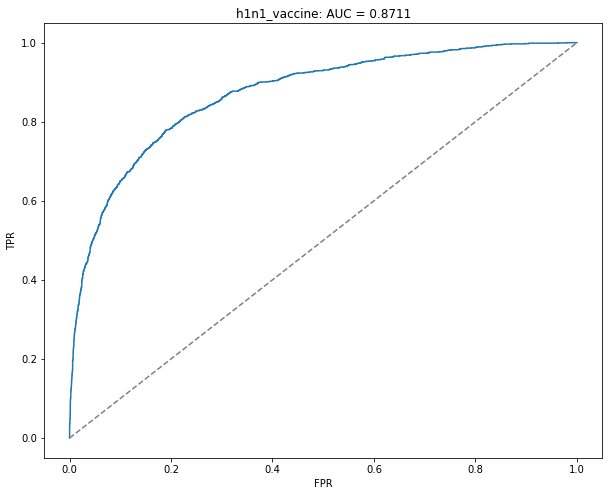

In [ ]:
# Menampilkan visualisasi plot roc auc
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# Memanggil fungsi plot_roc sesuai dengan parameter yang diinginkan
plot_roc(
    y_test['h1n1_vaccine'], 
    predictions_h1, 
    'h1n1_vaccine',
    ax=ax
)

In [ ]:
# Menampilkan nilai dari roc dan auc antara y_test dan predictions_h1
roc_auc_score(y_test.h1n1_vaccine, predictions_h1)

0.8710964730481472

Pada visualisasi dan code di atas dapat dilihat bahwa model memiliki nilai AUC (Area Under the ROC Curve) sebesar 0.8711 yang menunjukkan bahwa model machine learning yang digunakan memiliki performa yang cukup baik dalam memprediksi target variabel pada dataset yang digunakan. AUC berkisar antara 0 hingga 1, dimana semakin tinggi nilai AUC, maka semakin baik pula performa model dalam memprediksi target variabel. Dalam hal ini, nilai AUC sebesar 0.8711 menunjukkan bahwa model tersebut memiliki kemampuan yang cukup baik dalam membedakan antara TPR (True Positive Rate) dan FPR (False Positive Rate), yaitu dengan memprediksi nilai probabilitas yang lebih tinggi untuk TPR dibandingkan dengan FPR.

## Build Model for `seasonal_vaccine`

In [ ]:
# Membuat objek 'Pool' untuk Catboost yang merupakan struktur data yang digunakan untuk menyimpan data train model catboost
train_dataset_se = Pool(data=X_train, # Menspesifikkan feature yang digunakan untuk melatih model
                     label=y_train.seasonal_vaccine, # Menjabarkan variabel independen
                     cat_features = categorical_features_indices) # Mendeskripsikan kolom tertentu sebagai kolom kategorik

Membuat fungsi hyperparameter tuning kedua, yang memiliki beberapa perbedaan yang terletak pada rentang pada parameter yang diterapkan untuk model prediksi seasonal_vaccine

In [ ]:
# Membuat sebuah fungsi objective2 yang berfungsi untuk melakukan tuning
def objective2(trial):
    # Membuat parameter yang akan dilakukan tuning
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }
    # Melakukan Cross Validation pada model catboost dan memberikan hasil yang terbaik
    scores = cv(train_dataset_se, # Data yang digunakan adalah train_dataset
            param, # paramater yang digunakan adalah param
            fold_count=5, # melakukan cross validation dengan k-fold sebanyak 5
            early_stopping_rounds=10, # memberhentikan training lebih awal jika tidak ada kenaikan
            plot=False, verbose=False) #tidak melakukan plot learning curves dan tidak print verbose
    # Mereturn nilai mean AUC terbaik 
    return scores['test-AUC-mean'].max() 

In [ ]:
# Memasang seed 68 pada optuna
sampler = optuna.samplers.TPESampler(seed=68)
# Menciptakan objek studi optuna yang akan digunakan untuk mengoptimalkan hyperparameter dari model catboost
study2 = optuna.create_study(direction="maximize", sampler=sampler)
# Memulai proses optimalisasi dan secara berulang memanggil objective function yang mengevaluasi setiap kombinasi hasil hyperparameter
study2.optimize(objective2, n_trials=100)

[I 2021-02-17 01:58:46,608] A new study created in memory with name: no-name-03913ebf-5557-4268-9f2c-43f40117f5aa
[I 2021-02-17 01:59:12,754] Trial 0 finished with value: 0.8592774453063841 and parameters: {'iterations': 300, 'learning_rate': 0.013964954297408176, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 21.328495943450676, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8592774453063841.
[I 2021-02-17 01:59:26,032] Trial 1 finished with value: 0.8599969087296045 and parameters: {'iterations': 1200, 'learning_rate': 0.11477165079768124, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 0.5714362138520529, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8599969087296045.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:00:01,309] Trial 2 finished with value: 0.861608374321975 and parameters: {'iterations': 1500, 'learning_rate': 0.06018181691194878, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 7.937278880272323e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.861608374321975.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:00:14,015] Trial 3 finished with value: 0.8586019282142363 and parameters: {'iterations': 100, 'learning_rate': 0.04917655399574397, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 1.253388039132331e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.861608374321975.
[I 2021-02-17 02:00:27,447] Trial 4 finished with value: 0.8602753191026151 and parameters: {'iterations': 1500, 'learning_rate': 0.20567786125414012, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 2, 'l2_leaf_reg': 0.0011659140576640084, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.861608374321975.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:00:34,719] Trial 5 finished with value: 0.8567640003480698 and parameters: {'iterations': 100, 'learning_rate': 0.21103536986772822, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 1.5248267732768012e-08, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.861608374321975.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:10,069] Trial 6 finished with value: 0.8617699180315392 and parameters: {'iterations': 1000, 'learning_rate': 0.039222305770230614, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 3.544948380552023e-06, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:44,172] Trial 7 finished with value: 0.860718479761989 and parameters: {'iterations': 1000, 'learning_rate': 0.045869610193466345, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 6.629274905463984e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:48,686] Trial 8 finished with value: 0.8518659419954195 and parameters: {'iterations': 1500, 'learning_rate': 0.2775338323862574, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.0010943835695463693, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:52,676] Trial 9 finished with value: 0.8576354127969263 and parameters: {'iterations': 1000, 'learning_rate': 0.16527427195333977, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 5.547808519611033e-05, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:02:11,155] Trial 10 finished with value: 0.8616278814855303 and parameters: {'iterations': 500, 'learning_rate': 0.11039932312091873, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 1.2159249519874814e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:02:30,680] Trial 11 finished with value: 0.8613644301746106 and parameters: {'iterations': 500, 'learning_rate': 0.1084207966325659, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 1.2894289326228455e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:02:55,635] Trial 12 finished with value: 0.8357434471221705 and parameters: {'iterations': 500, 'learning_rate': 0.004806416713353634, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 6.39944753546505e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.
[I 2021-02-17 02:03:11,141] Trial 13 finished with value: 0.8616457635070617 and parameters: {'iterations': 1000, 'learning_rate': 0.10411608463872443, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 1.276003870120915e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:03:38,197] Trial 14 finished with value: 0.8619148959330752 and parameters: {'iterations': 1000, 'learning_rate': 0.07618156061546405, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 3, 'l2_leaf_reg': 3.5865647557736247e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:03:50,054] Trial 15 finished with value: 0.8549497979408294 and parameters: {'iterations': 1000, 'learning_rate': 0.06969554503907559, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 0.0002906071529974482, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:04:00,196] Trial 16 finished with value: 0.8609895930428383 and parameters: {'iterations': 200, 'learning_rate': 0.15325494851429844, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 6.938536064744217e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:05:03,898] Trial 17 finished with value: 0.8564992332206849 and parameters: {'iterations': 1000, 'learning_rate': 0.009317706201861467, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 0.04373352118950405, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.
[I 2021-02-17 02:05:09,478] Trial 18 finished with value: 0.8367012309165419 and parameters: {'iterations': 1000, 'learning_rate': 0.07767821367355207, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 2.5602616797376855e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:05:26,289] Trial 19 finished with value: 0.8498049035164978 and parameters: {'iterations': 300, 'learning_rate': 0.017984347045110226, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 3, 'l2_leaf_reg': 1.2398896982274805e-06, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.
[I 2021-02-17 02:06:08,776] Trial 20 finished with value: 0.8619727265448246 and parameters: {'iterations': 1200, 'learning_rate': 0.03236712628327796, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 0.046219859585272895, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8619727265448246.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:06:47,953] Trial 21 finished with value: 0.8597350906668979 and parameters: {'iterations': 1200, 'learning_rate': 0.03452823865248107, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 0.018537719843351754, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8619727265448246.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:07:08,229] Trial 22 finished with value: 0.8583524447935437 and parameters: {'iterations': 1200, 'learning_rate': 0.08575309147911239, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 0.3397573285506683, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8619727265448246.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:08:17,337] Trial 23 finished with value: 0.8624260361198551 and parameters: {'iterations': 1200, 'learning_rate': 0.027247202810574488, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 39.55970394954269, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:08:31,360] Trial 24 finished with value: 0.8609916595255 and parameters: {'iterations': 1200, 'learning_rate': 0.13650969502800792, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 14.889821880428762, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:10:14,239] Trial 25 finished with value: 0.861997483772733 and parameters: {'iterations': 1200, 'learning_rate': 0.02712686924609191, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 88.84655832391311, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:11:59,242] Trial 26 finished with value: 0.8622215414530657 and parameters: {'iterations': 1200, 'learning_rate': 0.027279570694869436, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 95.65012826306524, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:12:09,964] Trial 27 finished with value: 0.8582590962360153 and parameters: {'iterations': 1200, 'learning_rate': 0.29935905333625645, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 9, 'l2_leaf_reg': 88.42202477486413, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:14:34,841] Trial 28 finished with value: 0.8448933869047659 and parameters: {'iterations': 1200, 'learning_rate': 0.0012883179018759842, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 4.507225065456655, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.
[I 2021-02-17 02:15:00,735] Trial 29 finished with value: 0.8511466699775211 and parameters: {'iterations': 200, 'learning_rate': 0.018121978525421818, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 82.80146360137286, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.
[I 2021-02-17 02:16:10,806] Trial 30 finished with value: 0.8606369200848867 and parameters: {'iterations': 1200, 'learning_rate': 0.0253437097159

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:16:51,352] Trial 31 finished with value: 0.8624760408843091 and parameters: {'iterations': 1200, 'learning_rate': 0.05571026924312778, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 92.84631319598631, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:18:56,698] Trial 32 finished with value: 0.8422039202853909 and parameters: {'iterations': 1200, 'learning_rate': 0.0010313180718820245, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 24.67310566534338, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.
[I 2021-02-17 02:19:31,048] Trial 33 finished with value: 0.859487821029903 and parameters: {'iterations': 1200, 'learning_rate': 0.062100494868209254, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 1.2952184669897353, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:20:06,984] Trial 34 finished with value: 0.8617578410670788 and parameters: {'iterations': 300, 'learning_rate': 0.052470154488746826, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 45.787192748037945, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.
[I 2021-02-17 02:20:19,957] Trial 35 finished with value: 0.8616715967736706 and parameters: {'iterations': 1200, 'learning_rate': 0.09350163378814949, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 8.394192250872125, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:20:57,820] Trial 36 finished with value: 0.8611326533509001 and parameters: {'iterations': 1200, 'learning_rate': 0.051467883369440526, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 1.2592120964345, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:21:04,326] Trial 37 finished with value: 0.8448587047236252 and parameters: {'iterations': 100, 'learning_rate': 0.02568221228798362, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 87.48517216184811, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8624760408843091.
[I 2021-02-17 02:21:20,064] Trial 38 finished with value: 0.853128473568199 and parameters: {'iterations': 1200, 'learning_rate': 0.12773638178556146, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 0.22026399083527087, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:21:29,547] Trial 39 finished with value: 0.860400768400553 and parameters: {'iterations': 1200, 'learning_rate': 0.18799555523262435, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 22.52332464723313, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:22:06,265] Trial 40 finished with value: 0.861516799464793 and parameters: {'iterations': 1500, 'learning_rate': 0.042578219791789336, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 2.087481458571183, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:22:50,192] Trial 41 finished with value: 0.8609410005750432 and parameters: {'iterations': 1200, 'learning_rate': 0.030632757759002652, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 0.010120344084021772, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:23:14,283] Trial 42 finished with value: 0.8610182421679324 and parameters: {'iterations': 1200, 'learning_rate': 0.06461226321948788, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 0.054234637196588546, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:24:20,167] Trial 43 finished with value: 0.8628189010522164 and parameters: {'iterations': 1200, 'learning_rate': 0.04020226312212685, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 90.13854739728647, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:24:28,825] Trial 44 finished with value: 0.8535210908812981 and parameters: {'iterations': 100, 'learning_rate': 0.04924979597860921, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 40.94570190854328, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:26:30,637] Trial 45 finished with value: 0.8592894008103542 and parameters: {'iterations': 1200, 'learning_rate': 0.009427441664574057, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 10.287509791866576, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:26:39,562] Trial 46 finished with value: 0.8602585888878375 and parameters: {'iterations': 1200, 'learning_rate': 0.2533464487929

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:27:05,906] Trial 47 finished with value: 0.8614314481756443 and parameters: {'iterations': 1500, 'learning_rate': 0.09233047273917006, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 95.2433470499676, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:27:42,278] Trial 48 finished with value: 0.8620117436511997 and parameters: {'iterations': 500, 'learning_rate': 0.05910864313515036, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 4.8256119684481265, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:28:13,440] Trial 49 finished with value: 0.8620452402442842 and parameters: {'iterations': 500, 'learning_rate': 0.056721079608529255, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 5.3512189414574705, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:28:50,569] Trial 50 finished with value: 0.8622923239683138 and parameters: {'iterations': 500, 'learning_rate': 0.04192853723185702, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.6513400670834688, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:29:09,173] Trial 51 finished with value: 0.8568569561359218 and parameters: {'iterations': 200, 'learning_rate': 0.04160025060921315, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.7555161140528094, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:29:37,594] Trial 52 finished with value: 0.8621902474273602 and parameters: {'iterations': 500, 'learning_rate': 0.07329192392784331, 'random_strength': 9, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 14.58670726905145, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:30:02,870] Trial 53 finished with value: 0.8624964492575723 and parameters: {'iterations': 500, 'learning_rate': 0.07253083471785571, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 22.98843930329072, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:30:43,400] Trial 54 finished with value: 0.8576171145804865 and parameters: {'iterations': 500, 'learning_rate': 0.017936089217252614, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 31.27361535509004, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:31:04,463] Trial 55 finished with value: 0.8623314647519738 and parameters: {'iterations': 500, 'learning_rate': 0.08222021943922227, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 2.5013696924716973, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:31:18,140] Trial 56 finished with value: 0.8610512242661583 and parameters: {'iterations': 500, 'learning_rate': 0.11412893766081442, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.15433506787685775, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:31:36,692] Trial 57 finished with value: 0.8613923673116105 and parameters: {'iterations': 500, 'learning_rate': 0.085141915740434, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 2.5141006580046037, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:31:52,378] Trial 58 finished with value: 0.8612630878227835 and parameters: {'iterations': 500, 'learning_rate': 0.09589713030939544, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 0.43878407336956, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:32:07,086] Trial 59 finished with value: 0.8615545933637773 and parameters: {'iterations': 500, 'learning_rate': 0.12723347031619192, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 15.782010297515773, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:32:24,763] Trial 60 finished with value: 0.8603807833688792 and parameters: {'iterations': 500, 'learning_rate': 0.06767390848361435, 'random_strength': 6, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.0038331250495747165, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:32:48,765] Trial 61 finished with value: 0.8593328958417565 and parameters: {'iterations': 300, 'learning_rate': 0.04002795336574851, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 34.160901732588805, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:33:12,403] Trial 62 finished with value: 0.8612478466653123 and parameters: {'iterations': 500, 'learning_rate': 0.08298667194068889, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 8.990875597184502, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:33:58,208] Trial 63 finished with value: 0.8629142688449043 and parameters: {'iterations': 500, 'learning_rate': 0.03491751310099027, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 1.8211023402465396, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:34:31,979] Trial 64 finished with value: 0.8623054972865773 and parameters: {'iterations': 500, 'learning_rate': 0.04107559164106448, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.7995434990095341, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:34:54,473] Trial 65 finished with value: 0.8625410372679563 and parameters: {'iterations': 500, 'learning_rate': 0.07106096822317107, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 2.273919878847142, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:12,578] Trial 66 finished with value: 0.8619768911739152 and parameters: {'iterations': 500, 'learning_rate': 0.07435748178285664, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 2.341213045555641, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:27,906] Trial 67 finished with value: 0.8613733031099311 and parameters: {'iterations': 500, 'learning_rate': 0.10061698498467272, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 0.10944962662679808, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:51,483] Trial 68 finished with value: 0.8613503283172014 and parameters: {'iterations': 500, 'learning_rate': 0.05331669990575415, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.00018285984431075052, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:59,589] Trial 69 finished with value: 0.8566885276248998 and parameters: {'iterations': 100, 'learning_rate': 0.0641831119378872, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 6.043144943879615, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:36:50,508] Trial 70 finished with value: 0.8604960386211935 and parameters: {'iterations': 500, 'learning_rate': 0.013594721532242872, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 1.77312277797755, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:37:41,634] Trial 71 finished with value: 0.862710225312353 and parameters: {'iterations': 500, 'learning_rate': 0.0350151166318715, 'random_

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:38:21,519] Trial 72 finished with value: 0.8627817365905435 and parameters: {'iterations': 500, 'learning_rate': 0.035001908536129056, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 3.13127627723157, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:38:40,970] Trial 73 finished with value: 0.8567171783050588 and parameters: {'iterations': 200, 'learning_rate': 0.021780985189808935, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 16.13766517425775, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:39:20,994] Trial 74 finished with value: 0.8625779304204432 and parameters: {'iterations': 500, 'learning_rate': 0.03326560521656461, 'ran

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:41:35,123] Trial 78 finished with value: 0.861661843671647 and parameters: {'iterations': 500, 'learning_rate': 0.03262756198451842, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 3, 'l2_leaf_reg': 0.447397179748981, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:42:05,616] Trial 79 finished with value: 0.8624566134591856 and parameters: {'iterations': 500, 'learning_rate': 0.0452970152697529, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.023319854557215667, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:42:44,809] Trial 80 finished with value: 0.8540335533364083 and parameters: {'iterations': 500, 'learning_rate': 0.010032703148291439, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 1.027664406808666, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:43:19,053] Trial 81 finished with value: 0.8629017607304437 and parameters: {'iterations': 500, 'learning_rate': 0.0494773083884324, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 3.3307922351471193, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:43:50,426] Trial 82 finished with value: 0.8624013913198265 and parameters: {'iterations': 500, 'learning_rate': 0.049542492974861296, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 3, 'l2_leaf_reg': 0.20418092319233863, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:44:13,826] Trial 83 finished with value: 0.8619764751113526 and parameters: {'iterations': 500, 'learning_rate': 0.06873506936751295, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 3.5171984820667594, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:44:53,678] Trial 84 finished with value: 0.8627432322254434 and parameters: {'iterations': 500, 'learning_rate': 0.03421553291010362, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 1.279551978103478, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:45:36,135] Trial 85 finished with value: 0.8625860809785129 and parameters: {'iterations': 500, 'learning_rate': 0.033269810078548415, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 0.10983660655047413, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:46:15,406] Trial 86 finished with value: 0.8626428835931395 and parameters: {'iterations': 1500, 'learning_rate': 0.03404153880322145, 'random_strength': 3, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.11690785082262126, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:47:08,187] Trial 87 finished with value: 0.8626456622293277 and parameters: {'iterations': 1500, 'learning_rate': 0.020650041705929434, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.027931864894058415, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:48:24,535] Trial 88 finished with value: 0.8626965497081441 and parameters: {'iterations': 1500, 'learning_rate': 0.014966381186391205, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.02907660759142206, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:50:30,038] Trial 89 finished with value: 0.8510351179301624 and parameters: {'iterations': 1500, 'learning_rate': 0.0013992145042054163, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.012752600162201205, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:51:20,823] Trial 90 finished with value: 0.862443623043017 and parameters: {'iterations': 1500, 'learning_rate': 0.020255318965288774, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.0032786412356445942, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:52:32,738] Trial 91 finished with value: 0.8627868022639097 and parameters: {'iterations': 1500, 'learning_rate': 0.016208026164651508, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.03229965403267229, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:53:40,379] Trial 92 finished with value: 0.8623905719396159 and parameters: {'iterations': 1500, 'learning_rate': 0.016219596687074282, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.020324000210090877, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:54:17,055] Trial 93 finished with value: 0.8623952786907809 and parameters: {'iterations': 1500, 'learning_rate': 0.024683334828658334, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.005206609735610267, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:55:59,178] Trial 94 finished with value: 0.8601159023908957 and parameters: {'iterations': 1500, 'learning_rate': 0.006850829104537047, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 0.037270252908201226, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:57:17,634] Trial 95 finished with value: 0.863132450431481 and parameters: {'iterations': 1500, 'learning_rate': 0.015393853845985255, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.03977425239611938, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:58:40,984] Trial 96 finished with value: 0.8626726388656365 and parameters: {'iterations': 1500, 'learning_rate': 0.012469721707158859, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.0005650382037853742, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:59:33,794] Trial 97 finished with value: 0.8622695225487712 and parameters: {'iterations': 1500, 'learning_rate': 0.014165527219236959, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.00020647121997590114, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 03:00:14,194] Trial 98 finished with value: 0.8616028724032899 and parameters: {'iterations': 1500, 'learning_rate': 0.02661898255265924, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 0.0005062657170811357, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 03:02:18,705] Trial 99 finished with value: 0.8587725661746266 and parameters: {'iterations': 1500, 'learning_rate': 0.0033222800504134065, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.0014617936344147216, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


In [ ]:
# Menampilkan jumlah trial yang dilakukan dalam proses optimalisasi
print("Number of finished trials: {}".format(len(study2.trials)))
# Menampilkan hasil terbaik dalam proses optimalisasi
print("Best trial:")
# Memasukkan hasil terbaik yang ditemukan optuna ke dalam variable trial2
trial2 = study2.best_trial
# Menampilkan nilai dari hasil terbaik
print("  Value: {}".format(trial2.value))
# Menampilkan parameter yang digunakan pada hasil terbaik
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.863132450431481
  Params: 
    iterations=1500,
    learning_rate=0.015393853845985255,
    random_strength=3,
    bagging_temperature=7,
    max_bin=8,
    grow_policy=Lossguide,
    min_data_in_leaf=1,
    max_depth=5,
    l2_leaf_reg=0.03977425239611938,
    one_hot_max_size=500,
    auto_class_weights=Balanced,


In [ ]:
# Membuat ulang model catboost dengan parameter terbaik yang ditemukan
final_model_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                                    **trial2.params)

# Mengimplementasikan model yang sudah dibuat kepada X_train dan y_train
final_model_se.fit(X_train, y_train.seasonal_vaccine)

### Evaluate the `seasonal_vaccine` Model

Memprediksi kelas dari data test X_test

In [ ]:
# Memprediksi nilai probabilitas prediksi dari X-test menggunakan model yang sudah dibuat
predictions_se = final_model_se.predict_proba(X_test)

# Mengambil kolom kedua dari array predictions_se dan mengubah kolom tersebut menjadi array baru dengan satu kolom dan jumlah baris yang sama dengan array input
predictions_se = predictions_se[:,1].reshape(-1,1)

Melakukan visualisasi grafik roc dan auc dari model prediksi seasonal_vaccine

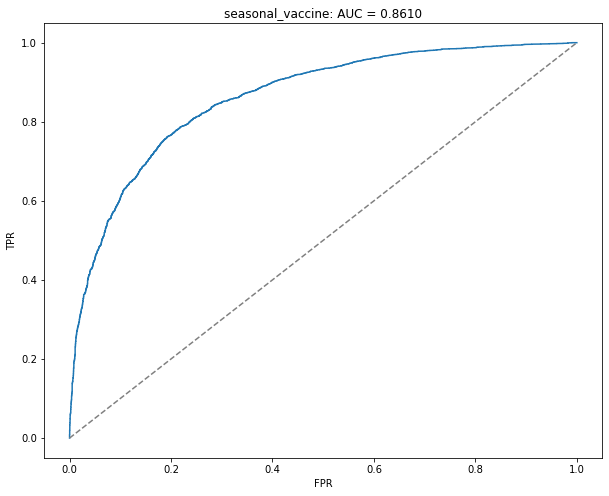

In [ ]:
# Melakukan visualisasi roc auc
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# Memanggil fungsi plot_roc dengan parameter yang diinginkan
plot_roc(
    y_test['seasonal_vaccine'], 
    predictions_se, 
    'seasonal_vaccine',
    ax=ax
)

In [ ]:
# Menampilkan nilai roc auc dari y_test dan predictions_se
roc_auc_score(y_test.seasonal_vaccine, predictions_se)

0.8610242609729017

Pada visualisasi dan code di atas dapat dilihat bahwa model memiliki nilai AUC (Area Under the ROC Curve) sebesar 0.8711 yang menunjukkan bahwa model machine learning yang digunakan memiliki performa yang cukup baik dalam memprediksi target variabel pada dataset yang digunakan. AUC berkisar antara 0 hingga 1, dimana semakin tinggi nilai AUC, maka semakin baik pula performa model dalam memprediksi target variabel. Dalam hal ini, nilai AUC sebesar 0.8711 menunjukkan bahwa model tersebut memiliki kemampuan yang cukup baik dalam membedakan antara TPR (True Positive Rate) dan FPR (False Positive Rate), yaitu dengan memprediksi nilai probabilitas yang lebih tinggi untuk TPR dibandingkan dengan FPR.

## Combined Score

Karena kasus yang ditangani merupakan multiclass classification, sedangkan pada code di atas hanya menampilkan hasil evaluasi dari setiap model yang memprediksi variabel target yang berbeda. Perlu dilakukan penggabungan untuk melihat evaluasi kedua model secara keseluruhan.

In [ ]:
# Menampilkan nilai roc aud gabungan dari kedua hasil prediksi
roc_auc_score(y_test, np.hstack((predictions_h1, predictions_se)))

0.8660603670105245

Hasil ROC AUC pada multiclass classification sebesar 0.866 yang merupakan angka yang cukup besar, yang berarti model memiliki nilai True Positive Rate yang cukup besar dengan False Positive rate yang cukup kecil.

# Retrain on Full Dataset

Pada evaluasi model sebelumnya, kita masih menggunakan X-train dan y_train yang berukuran 0.7 dari dataset train sebagai variabel yang di fitting ke dalam model agar dapat mendapatkan evaluasi yang tidak terpengaruh oleh kebocoran data. Namun untuk meningkatkan performa dari model kita, perlu dilakukan fitting kembali dengan keseluruhan dataset train (variabel independen) dan labels (variabel target). Oleh karena itu dilakukan fitting kembali dengan menggunakan keseluruhan data, dan melakukan prediksi menggunakan model tersebut.

## `seasonal_vaccine` model

In [ ]:
# Melakukan fit pada model seasonal dengan data train dan label seasonal
final_model_se.fit(train, labels.seasonal_vaccine)

# Memprediksi probabilitas prediksi test menggunakan model yang telah dibuat
final_se = final_model_se.predict_proba(test)

# Mengambil kolom kedua dari array final_se dan mengubah kolom tersebut menjadi array baru dengan satu kolom dan jumlah baris yang sama dengan array input
final_se = final_se[:,1].reshape(-1,1)

## `h1n1_vaccine` model

In [ ]:
# Melakukan fit pada model h1n1 dengan data train dan label h1n1
final_model.fit(train, labels.h1n1_vaccine)

# Memprediksi probabilitas prediksi test menggunakan model yang telah dibuat
final_h1 = final_model.predict_proba(test)

# Mengambil kolom kedua dari array final h1n1 dan mengubah kolom tersebut menjadi array baru dengan satu kolom dan jumlah baris yang sama dengan array input
final_h1 = final_h1[:,1].reshape(-1,1)

# Make Submission

Membuat file submission yang sesuai dengan format yang ada.

In [ ]:
# Membaca dataframe submission
submission_df = pd.read_csv("./submission_format.csv", 
                            index_col="respondent_id")

In [ ]:
# Memastikan row memiliki urutan yang sama
np.testing.assert_array_equal(test.index.values, 
                              submission_df.index.values)

# Memasukkan hasil prediksi ke dalam dataframe submission_df
submission_df["h1n1_vaccine"] = final_h1
submission_df["seasonal_vaccine"] = final_se
# Menampilkan 5 data teratas submission_df
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.370448,0.273193
26708,0.079469,0.044629
26709,0.504887,0.735957
26710,0.879725,0.891950
26711,0.687898,0.509354
